# SmallGrayReg: Cats vs Dogs: VGG19

Using the Cat vs Dog dataset, we will read the data files into memory as-is. The preprocessing of this image will be to resized to smaller dimensions, convert to grayscale, and a min-max scaling will be performed on the pixel values of the image (divide by 255, which is the maximum possible value a pixel can hold). We will feed the processed dataset into a Convolutional Neural Network modeled to use the VGG19 architecture, which will be trained for 25 epochs. This is intended to show the standard preprocessing techniques used for image processing.

## Imports

Before we begin, we need to import the necessary python packages and appropriately configure the tensorflow gpu enviornment for use with the correct GPU on this system (RTX 2070 in GPU slot 0). 

* **`numpy`:** used for matrix operations, storing the pixel data of the images while working
* **`pandas`:** used for tabular organization of the results for storing in a formatted csv style for later evaluation in another notebook
* **`matplotlib.pyplot`:** used for data visualization for the model performance after training
* **`cv2`:** OpenCV for python, used for reading and manipulating the image files from the dataset before storing in working memory.
* **`os`:** used for streamlined access of the filesystem for determining the paths to each of the data files
* **`tensorflow.keras`:** used for model creation, compiling, and training. The GPU variant of tensorflow was used; this program has not been tested for systems without access to the GPU acclerations. 
* **`sklearn.utils.shuffle`:** used for an efficient shuffling of the X and y datasets together. 
* **`timeit.default_timer`:** used for timing the overhead and training runtime performance of the model when no preprocessing is performed

In [1]:
# === Imports === #
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import kerastuner        as kt
import cv2
import os
from tensorflow    import keras
from sklearn.utils import shuffle
from timeit        import default_timer


# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# === Total Times Log === #
times = list( )

## Determine Train/Test Data Files

First, we need to determine the files which are to be used for training and validation. In order to do this, we will use our knowledge of the filesystem structure for the project, as well as the os listdir function to produce two lists: one of the filepaths used for the training data, and one of the filepaths used for the validation data. Finally, the first ten items of each list are printed to verify the success of the file list creation. 

In [2]:
# === Setup Variables === #
data_root_dir   = 'Dataset/Dog_vs_Cat/'
data_classes    = os.listdir( data_root_dir + 'training_set/' )
training_subdir = 'training_set/'
testing_subdir  = 'test_set/'
training_files  = [ ]
testing_files   = [ ]


# === For Each Class, Add Files to Appropriate List === #
for data_class in data_classes:
    for f in os.listdir( data_root_dir + training_subdir + data_class + '/' ):
        training_files.append( data_root_dir + training_subdir + data_class + '/' + f )
    for f in os.listdir( data_root_dir + testing_subdir + data_class + '/' ):
        testing_files.append( data_root_dir + testing_subdir + data_class + '/' + f )

    
# === Show First 10 of Each to Prove Success === #
print( 'Training Set:\n{}'.format( training_files[:10] ) )
print( '\nTesting Set: \n{}'.format( testing_files[:10] ) )

Training Set:
['Dataset/Dog_vs_Cat/training_set/cats/cat.1.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.10.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.100.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1000.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1001.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1002.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1003.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1004.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1005.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1006.jpg']

Testing Set: 
['Dataset/Dog_vs_Cat/test_set/cats/cat.4001.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4002.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4003.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4004.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4005.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4006.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4007.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4008.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4009.jpg', 'Dat

## Get Image Data & Label from File Names

Using our two file lists, we need to read the image data into working memory for the model to use in the training process. Since our model requires all training and validation data to be of the same shape, reshaping the image as its read will be the only transformation performed on the data. Analyzing the dataset showed that the average training image shape was `(360,400)`. In order to maintain the integrity of the experiment, all images were manually reshaped to be a square which is a factor of of this larger dimension `(400,400) --> (80,80)`. We also convert the read images into float32 for post-regularization data

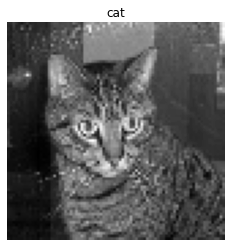

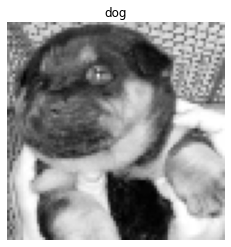

In [3]:
# ================================================================================
# FUNCTION: files_to_Xy( file_list , desired_shape )
# ================================================================================
# 
# Input: 
#   - file_list: list of filepaths to be read (as generated in the previous cell)
#   - desired_shape (optional): dimensions to transform the image data into
#        * default = (80,80): a 80x80 grayscale image
#
# Output:
#   - Numpy array of shape (n,h,w,c) containing every image present in the list
#        * n = number of images listed to be read
#        * h = first dimension of desired_shape: height of image 
#        * w = second dimension of desired_shape: width of image
#        * c = third dimension of desired_shape: number of channels in the image (gray=1)
#
# Task:
#   1. Iterate over the file list
#   2. Parse the y label for the image out of the file path
#   3. Use OpenCV (cv2) to read the image data and reshape appropriately
#   4. store the image data/label into numpy arrays of the desired shape
#   5. return the populated X and y after finished iterating
#
# ================================================================================
def files_to_Xy( file_list , desired_shape=(80,80) ):
    
    # === Setup Variables === #
    X = np.empty( (len( file_list ), desired_shape[0], desired_shape[1] ) , dtype=np.float32 )
    y = np.empty( len( file_list ) , dtype=object )
    
    # === Iterate Files === #
    for i in range( len( file_list ) ):
        y[i] = file_list[i][ file_list[i].rfind('/')+1:file_list[i].index( '.' ) ]  # either "dog" or "cat"
        X[i] = cv2.resize( 
                    cv2.imread( file_list[i] , cv2.IMREAD_GRAYSCALE ), 
                    ( desired_shape[0] , desired_shape[1] ) 
                ) / 255
        
    # === Return Results === #
    return X.reshape( X.shape[0] , X.shape[1], X.shape[2], 1 ) , y



# ================================================================================
# FUNCTION: show_image( X , y , idx )
# ================================================================================
#
# Input:
#   - X: numpy array containing the image data
#   - y: numpy array containing the corresponding class labels
#   - idx: index of the image to be shown
#
# Output:
#   - no return
#   - matplotlib imshow figure displayed
#
# Task:
#   1. using matplotlib.pyplot.imshow() to display the specified image
#
# Note:
#   - This function is not necessary for program completion, but it serves as a 
#     utility function to help demonstrate the success of the other necessary 
#     functions. 
#
# ================================================================================
def show_image( X , y , idx ):
    plt.figure( )
    plt.axis( 'off' )
    plt.imshow( X[idx] , cmap='gray' )
    plt.title( y[idx] )
    plt.show( )
        
        
        
# === Use Function to Get Train/Test Data === #
start             = default_timer( )
X_train , y_train = files_to_Xy( training_files )
X_test  , y_test  = files_to_Xy( testing_files  )
end               = default_timer( )
times.append( { 'Event': 'Load/Process Dataset' , 'Time (sec)': end - start } )



# === Show First and Last Images and Classes as Proof === #
show_image( X_train , y_train , 0 )
show_image( X_train , y_train , y_train.shape[0] - 1 )

## Shuffle the Training Data

Shuffling the training data is an important step to be performed before training any model. This helps to allow fairness in the training, and ensure the model is learning most effectively without encountering any biases due to ordering (for example, all cats are listed before all dogs currently, so the model may overfit to dogs before learning anything about cats).

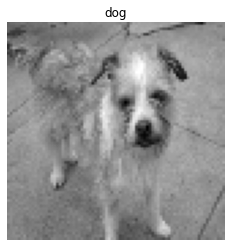

In [4]:
# === Shuffle X and y Together === #
X_train , y_train = shuffle( X_train , y_train )

# === Prove by Printing First Again to show it's Different === #
show_image( X_train , y_train , 0 )

## Convert Classes from Strings to Integers

Keras models don't handle categorical classes as well as numerical classes -- especially fora  binary classifier. Because of this, instead of having two class categories, we will translate the two possible classes to either a zero or a one to let the numerical output of the model specify the predicted class of the data. 

    Cat --> 0
    Dog --> 1

This translation is performed against both the training and validation labels. 

In [5]:
# === Key to Translate in Either Direction
label_keys = {
    'cat' : 0,
    'dog' : 1,
    0     : 'cat',
    1     : 'dog'
}

# === Update Training y === #
y_train[y_train=='cat'] = 0
y_train[y_train=='dog'] = 1
y_train = y_train.astype( X_train.dtype )

# === Update Testing y === #
y_test[y_test=='cat'] = 0
y_test[y_test=='dog'] = 1
y_test = y_test.astype( X_test.dtype )

# === Prove Success === #
y_train

array([1., 0., 1., ..., 0., 0., 0.], dtype=float32)

## Create Model with Tuning Options

We will be using a convolutional neural network, whose layers are specified to resemble the VGG19 model architecture. Consisting of 5 convolution blocks: 2x64, 2x128, 4x256, 4x512, 4x512. Each convolution block has a 2x2 pooling layer at the end of the block. After the five convolution blocks, the model is flattened, connected to a 1024 depth dense layer, then a dropout of 0.3, then a 64 depth dense layer, and finally a 1-depth dense layer for output. the ReLU activation function is used for all relevant layers with the exception of the output layer, which uses the softmax activation since this is a multi-class classification problem. 

In terms of tuning, we will test ten different learning rates between `1e-5` and `1e-4` in order to determine which one best converges the model in terms of accuracy. 

In [6]:
def model_builder( hp ):
    model_layers = [
        keras.Input( shape=X_train[0].shape , name='Input_Layer' ),
    
        keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_1' , padding='same' ),
        keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_2' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_1_Pooling' ),

        keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_1' , padding='same' ),
        keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_2' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_2_Pooling' ),

        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_1' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_2' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_3' , padding='same' ),
        keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_3_Pooling' ),

        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_1' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_2' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_3' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_4_Pooling' ),

        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_1' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_2' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_3' , padding='same' ),
        keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_4' , padding='same' ),
        keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_5_Pooling' ),

        keras.layers.Flatten( ),

        keras.layers.Dense( 1024 , activation='relu' ),
        keras.layers.Dropout( 0.3 ),

        keras.layers.Dense( 64 , activation='relu' ),
        keras.layers.Dropout( 0.3 ),

        keras.layers.Dense( 1 , activation='sigmoid' )
    ]
    model            = keras.Sequential( layers=model_layers )
    hp_learning_rate = hp.Choice('learning_rate', values=list(np.linspace(0.000001, 0.00001, 10)))
    optimizer        = keras.optimizers.Adam( lr=hp_learning_rate )
    model.compile( optimizer=optimizer , loss="binary_crossentropy" , metrics=["accuracy"])
    return model

## Tune the Model

Using the keras-tuner package, we will tune the learning rate for the model in order to achieve the optimal validation accuracy via the hyperband tuning altorithm. This value may overfit, but it shows an example of how light tuning may result in better val accuracy in an automated tuning for this specific model architecture. 

In [7]:
start      = default_timer( )
tuner      = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, hyperband_iterations=10, directory=os.path.normpath('C:/Users/dryyo/Documents/keras_tuner'), project_name='SmallGrayReg' , overwrite=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_early])
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]
end        = default_timer( )
times.append( { 'Event': 'Hyperparameter Tuning' , 'Time (sec)': end - start } )

print('The Optimal Leanring Rate is: {}'.format(best_hps.get('learning_rate')))

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


5936/8000 [=====================>........] - ETA: 23:20 - loss: 0.6931 - accuracy: 0.562 - ETA: 7:58 - loss: 0.6931 - accuracy: 0.479 - ETA: 4:53 - loss: 0.6932 - accuracy: 0.46 - ETA: 3:34 - loss: 0.6932 - accuracy: 0.43 - ETA: 2:50 - loss: 0.6932 - accuracy: 0.45 - ETA: 2:22 - loss: 0.6932 - accuracy: 0.43 - ETA: 2:03 - loss: 0.6932 - accuracy: 0.44 - ETA: 1:49 - loss: 0.6932 - accuracy: 0.46 - ETA: 1:38 - loss: 0.6932 - accuracy: 0.46 - ETA: 1:29 - loss: 0.6932 - accuracy: 0.47 - ETA: 1:22 - loss: 0.6932 - accuracy: 0.47 - ETA: 1:16 - loss: 0.6932 - accuracy: 0.47 - ETA: 1:11 - loss: 0.6932 - accuracy: 0.48 - ETA: 1:07 - loss: 0.6931 - accuracy: 0.49 - ETA: 1:03 - loss: 0.6931 - accuracy: 0.49 - ETA: 1:00 - loss: 0.6931 - accuracy: 0.49 - ETA: 58s - loss: 0.6931 - accuracy: 0.4924 - ETA: 55s - loss: 0.6931 - accuracy: 0.498 - ETA: 53s - loss: 0.6931 - accuracy: 0.508 - ETA: 51s - loss: 0.6931 - accuracy: 0.506 - ETA: 49s - loss: 0.6931 - accuracy: 0.504 - ETA: 47s - loss: 0.6931 - a

8000/8000 [==============================] - ETA: 6s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accura

6000/8000 [=====================>........] - ETA: 20s - loss: 0.6926 - accuracy: 0.750 - ETA: 20s - loss: 0.6930 - accuracy: 0.583 - ETA: 20s - loss: 0.6931 - accuracy: 0.575 - ETA: 20s - loss: 0.6931 - accuracy: 0.553 - ETA: 19s - loss: 0.6931 - accuracy: 0.548 - ETA: 19s - loss: 0.6931 - accuracy: 0.556 - ETA: 19s - loss: 0.6931 - accuracy: 0.543 - ETA: 19s - loss: 0.6931 - accuracy: 0.525 - ETA: 19s - loss: 0.6931 - accuracy: 0.529 - ETA: 19s - loss: 0.6931 - accuracy: 0.532 - ETA: 19s - loss: 0.6931 - accuracy: 0.538 - ETA: 19s - loss: 0.6931 - accuracy: 0.543 - ETA: 19s - loss: 0.6930 - accuracy: 0.545 - ETA: 19s - loss: 0.6931 - accuracy: 0.537 - ETA: 19s - loss: 0.6931 - accuracy: 0.534 - ETA: 19s - loss: 0.6930 - accuracy: 0.546 - ETA: 19s - loss: 0.6930 - accuracy: 0.539 - ETA: 18s - loss: 0.6930 - accuracy: 0.528 - ETA: 18s - loss: 0.6930 - accuracy: 0.535 - ETA: 18s - loss: 0.6930 - accuracy: 0.533 - ETA: 18s - loss: 0.6930 - accuracy: 0.530 - ETA: 18s - loss: 0.6930 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6926 - accuracy: 0.52 - ETA: 4s - loss: 0.6926 - accuracy: 0.52 - ETA: 4s - loss: 0.6926 - accuracy: 0.52 - ETA: 4s - loss: 0.6926 - accuracy: 0.52 - ETA: 4s - loss: 0.6926 - accuracy: 0.52 - ETA: 4s - loss: 0.6926 - accuracy: 0.52 - ETA: 4s - loss: 0.6926 - accuracy: 0.52 - ETA: 4s - loss: 0.6926 - accuracy: 0.52 - ETA: 4s - loss: 0.6926 - accuracy: 0.52 - ETA: 4s - loss: 0.6926 - accuracy: 0.52 - ETA: 4s - loss: 0.6925 - accuracy: 0.52 - ETA: 4s - loss: 0.6925 - accuracy: 0.52 - ETA: 4s - loss: 0.6925 - accuracy: 0.52 - ETA: 3s - loss: 0.6925 - accuracy: 0.52 - ETA: 3s - loss: 0.6925 - accuracy: 0.52 - ETA: 3s - loss: 0.6925 - accuracy: 0.52 - ETA: 3s - loss: 0.6926 - accuracy: 0.52 - ETA: 3s - loss: 0.6925 - accuracy: 0.52 - ETA: 3s - loss: 0.6925 - accuracy: 0.52 - ETA: 3s - loss: 0.6926 - accuracy: 0.52 - ETA: 3s - loss: 0.6926 - accuracy: 0.52 - ETA: 3s - loss: 0.6926 - accuracy: 0.52 - ETA: 3s - loss: 0.6926 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


5968/8000 [=====================>........] - ETA: 6:53 - loss: 0.6932 - accuracy: 0.43 - ETA: 2:31 - loss: 0.6932 - accuracy: 0.52 - ETA: 1:38 - loss: 0.6931 - accuracy: 0.48 - ETA: 1:15 - loss: 0.6932 - accuracy: 0.50 - ETA: 1:03 - loss: 0.6931 - accuracy: 0.51 - ETA: 55s - loss: 0.6931 - accuracy: 0.4943 - ETA: 49s - loss: 0.6932 - accuracy: 0.490 - ETA: 45s - loss: 0.6932 - accuracy: 0.491 - ETA: 42s - loss: 0.6932 - accuracy: 0.489 - ETA: 39s - loss: 0.6932 - accuracy: 0.486 - ETA: 37s - loss: 0.6932 - accuracy: 0.476 - ETA: 35s - loss: 0.6932 - accuracy: 0.467 - ETA: 34s - loss: 0.6932 - accuracy: 0.472 - ETA: 33s - loss: 0.6932 - accuracy: 0.483 - ETA: 32s - loss: 0.6931 - accuracy: 0.497 - ETA: 31s - loss: 0.6931 - accuracy: 0.502 - ETA: 30s - loss: 0.6931 - accuracy: 0.507 - ETA: 29s - loss: 0.6931 - accuracy: 0.505 - ETA: 28s - loss: 0.6931 - accuracy: 0.503 - ETA: 28s - loss: 0.6932 - accuracy: 0.500 - ETA: 27s - loss: 0.6932 - accuracy: 0.495 - ETA: 27s - loss: 0.6931 - accu

8000/8000 [==============================] - ETA: 5s - loss: 0.6931 - accuracy: 0.49 - ETA: 5s - loss: 0.6931 - accuracy: 0.49 - ETA: 5s - loss: 0.6931 - accuracy: 0.49 - ETA: 5s - loss: 0.6931 - accuracy: 0.49 - ETA: 5s - loss: 0.6931 - accuracy: 0.49 - ETA: 5s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 3s - loss: 0.6931 - accuracy: 0.49 - ETA: 3s - loss: 0.6931 - accuracy: 0.49 - ETA: 3s - loss: 0.6931 - accuracy: 0.49 - ETA: 3s - loss: 0.6931 - accuracy: 0.49 - ETA: 3s - loss: 0.6931 - accuracy: 0.49 - ETA: 3s - loss: 0.6931 - accura

6000/8000 [=====================>........] - ETA: 20s - loss: 0.6920 - accuracy: 0.562 - ETA: 20s - loss: 0.6916 - accuracy: 0.583 - ETA: 20s - loss: 0.6915 - accuracy: 0.587 - ETA: 20s - loss: 0.6915 - accuracy: 0.580 - ETA: 20s - loss: 0.6921 - accuracy: 0.548 - ETA: 20s - loss: 0.6928 - accuracy: 0.517 - ETA: 20s - loss: 0.6928 - accuracy: 0.514 - ETA: 20s - loss: 0.6927 - accuracy: 0.512 - ETA: 20s - loss: 0.6932 - accuracy: 0.496 - ETA: 20s - loss: 0.6933 - accuracy: 0.490 - ETA: 20s - loss: 0.6930 - accuracy: 0.503 - ETA: 20s - loss: 0.6930 - accuracy: 0.502 - ETA: 20s - loss: 0.6929 - accuracy: 0.502 - ETA: 20s - loss: 0.6930 - accuracy: 0.495 - ETA: 19s - loss: 0.6931 - accuracy: 0.491 - ETA: 19s - loss: 0.6932 - accuracy: 0.485 - ETA: 19s - loss: 0.6932 - accuracy: 0.484 - ETA: 19s - loss: 0.6930 - accuracy: 0.498 - ETA: 19s - loss: 0.6932 - accuracy: 0.486 - ETA: 19s - loss: 0.6933 - accuracy: 0.479 - ETA: 19s - loss: 0.6933 - accuracy: 0.483 - ETA: 19s - loss: 0.6932 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6923 - accuracy: 0.51 - ETA: 5s - loss: 0.6923 - accuracy: 0.51 - ETA: 5s - loss: 0.6923 - accuracy: 0.51 - ETA: 4s - loss: 0.6924 - accuracy: 0.51 - ETA: 4s - loss: 0.6924 - accuracy: 0.51 - ETA: 4s - loss: 0.6924 - accuracy: 0.51 - ETA: 4s - loss: 0.6923 - accuracy: 0.51 - ETA: 4s - loss: 0.6923 - accuracy: 0.51 - ETA: 4s - loss: 0.6923 - accuracy: 0.51 - ETA: 4s - loss: 0.6922 - accuracy: 0.51 - ETA: 4s - loss: 0.6921 - accuracy: 0.51 - ETA: 4s - loss: 0.6920 - accuracy: 0.51 - ETA: 4s - loss: 0.6920 - accuracy: 0.51 - ETA: 4s - loss: 0.6920 - accuracy: 0.51 - ETA: 4s - loss: 0.6919 - accuracy: 0.51 - ETA: 3s - loss: 0.6918 - accuracy: 0.51 - ETA: 3s - loss: 0.6919 - accuracy: 0.51 - ETA: 3s - loss: 0.6921 - accuracy: 0.51 - ETA: 3s - loss: 0.6921 - accuracy: 0.51 - ETA: 3s - loss: 0.6922 - accuracy: 0.51 - ETA: 3s - loss: 0.6922 - accuracy: 0.51 - ETA: 3s - loss: 0.6922 - accuracy: 0.51 - ETA: 3s - loss: 0.6922 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


5936/8000 [=====================>........] - ETA: 7:31 - loss: 0.6932 - accuracy: 0.43 - ETA: 2:45 - loss: 0.6932 - accuracy: 0.45 - ETA: 1:47 - loss: 0.6932 - accuracy: 0.51 - ETA: 1:22 - loss: 0.6932 - accuracy: 0.50 - ETA: 1:08 - loss: 0.6932 - accuracy: 0.50 - ETA: 59s - loss: 0.6931 - accuracy: 0.5170 - ETA: 53s - loss: 0.6932 - accuracy: 0.504 - ETA: 48s - loss: 0.6931 - accuracy: 0.500 - ETA: 45s - loss: 0.6931 - accuracy: 0.496 - ETA: 42s - loss: 0.6932 - accuracy: 0.483 - ETA: 40s - loss: 0.6932 - accuracy: 0.485 - ETA: 38s - loss: 0.6932 - accuracy: 0.481 - ETA: 36s - loss: 0.6932 - accuracy: 0.485 - ETA: 35s - loss: 0.6932 - accuracy: 0.474 - ETA: 34s - loss: 0.6932 - accuracy: 0.474 - ETA: 32s - loss: 0.6932 - accuracy: 0.469 - ETA: 32s - loss: 0.6932 - accuracy: 0.467 - ETA: 31s - loss: 0.6932 - accuracy: 0.466 - ETA: 30s - loss: 0.6932 - accuracy: 0.474 - ETA: 29s - loss: 0.6932 - accuracy: 0.479 - ETA: 29s - loss: 0.6932 - accuracy: 0.478 - ETA: 28s - loss: 0.6931 - accu

8000/8000 [==============================] - ETA: 5s - loss: 0.6931 - accuracy: 0.49 - ETA: 5s - loss: 0.6931 - accuracy: 0.49 - ETA: 5s - loss: 0.6931 - accuracy: 0.49 - ETA: 5s - loss: 0.6931 - accuracy: 0.49 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accuracy: 0.49 - ETA: 3s - loss: 0.6931 - accuracy: 0.49 - ETA: 3s - loss: 0.6931 - accuracy: 0.49 - ETA: 3s - loss: 0.6931 - accura

6000/8000 [=====================>........] - ETA: 20s - loss: 0.6978 - accuracy: 0.437 - ETA: 20s - loss: 0.6956 - accuracy: 0.416 - ETA: 20s - loss: 0.6963 - accuracy: 0.412 - ETA: 20s - loss: 0.6953 - accuracy: 0.437 - ETA: 20s - loss: 0.6940 - accuracy: 0.465 - ETA: 20s - loss: 0.6935 - accuracy: 0.483 - ETA: 20s - loss: 0.6935 - accuracy: 0.480 - ETA: 20s - loss: 0.6932 - accuracy: 0.487 - ETA: 20s - loss: 0.6926 - accuracy: 0.511 - ETA: 20s - loss: 0.6921 - accuracy: 0.519 - ETA: 20s - loss: 0.6927 - accuracy: 0.503 - ETA: 20s - loss: 0.6925 - accuracy: 0.505 - ETA: 20s - loss: 0.6926 - accuracy: 0.500 - ETA: 19s - loss: 0.6924 - accuracy: 0.506 - ETA: 19s - loss: 0.6928 - accuracy: 0.495 - ETA: 19s - loss: 0.6929 - accuracy: 0.496 - ETA: 19s - loss: 0.6923 - accuracy: 0.507 - ETA: 19s - loss: 0.6926 - accuracy: 0.505 - ETA: 19s - loss: 0.6928 - accuracy: 0.501 - ETA: 19s - loss: 0.6928 - accuracy: 0.504 - ETA: 19s - loss: 0.6929 - accuracy: 0.503 - ETA: 19s - loss: 0.6927 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6913 - accuracy: 0.52 - ETA: 5s - loss: 0.6912 - accuracy: 0.52 - ETA: 5s - loss: 0.6911 - accuracy: 0.52 - ETA: 5s - loss: 0.6911 - accuracy: 0.52 - ETA: 4s - loss: 0.6911 - accuracy: 0.52 - ETA: 4s - loss: 0.6910 - accuracy: 0.52 - ETA: 4s - loss: 0.6910 - accuracy: 0.52 - ETA: 4s - loss: 0.6909 - accuracy: 0.52 - ETA: 4s - loss: 0.6907 - accuracy: 0.52 - ETA: 4s - loss: 0.6908 - accuracy: 0.52 - ETA: 4s - loss: 0.6907 - accuracy: 0.52 - ETA: 4s - loss: 0.6903 - accuracy: 0.52 - ETA: 4s - loss: 0.6901 - accuracy: 0.52 - ETA: 4s - loss: 0.6902 - accuracy: 0.52 - ETA: 4s - loss: 0.6907 - accuracy: 0.52 - ETA: 3s - loss: 0.6906 - accuracy: 0.52 - ETA: 3s - loss: 0.6906 - accuracy: 0.52 - ETA: 3s - loss: 0.6905 - accuracy: 0.52 - ETA: 3s - loss: 0.6903 - accuracy: 0.52 - ETA: 3s - loss: 0.6903 - accuracy: 0.52 - ETA: 3s - loss: 0.6902 - accuracy: 0.52 - ETA: 3s - loss: 0.6902 - accuracy: 0.52 - ETA: 3s - loss: 0.6901 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


5936/8000 [=====================>........] - ETA: 7:09 - loss: 0.6932 - accuracy: 0.37 - ETA: 2:38 - loss: 0.6932 - accuracy: 0.54 - ETA: 1:43 - loss: 0.6932 - accuracy: 0.47 - ETA: 1:19 - loss: 0.6931 - accuracy: 0.50 - ETA: 1:06 - loss: 0.6931 - accuracy: 0.47 - ETA: 57s - loss: 0.6931 - accuracy: 0.4943 - ETA: 52s - loss: 0.6931 - accuracy: 0.519 - ETA: 47s - loss: 0.6931 - accuracy: 0.504 - ETA: 44s - loss: 0.6931 - accuracy: 0.492 - ETA: 41s - loss: 0.6931 - accuracy: 0.483 - ETA: 39s - loss: 0.6931 - accuracy: 0.494 - ETA: 37s - loss: 0.6931 - accuracy: 0.508 - ETA: 36s - loss: 0.6931 - accuracy: 0.515 - ETA: 34s - loss: 0.6931 - accuracy: 0.516 - ETA: 33s - loss: 0.6931 - accuracy: 0.515 - ETA: 32s - loss: 0.6931 - accuracy: 0.506 - ETA: 31s - loss: 0.6931 - accuracy: 0.503 - ETA: 30s - loss: 0.6931 - accuracy: 0.505 - ETA: 30s - loss: 0.6931 - accuracy: 0.498 - ETA: 29s - loss: 0.6931 - accuracy: 0.496 - ETA: 28s - loss: 0.6932 - accuracy: 0.495 - ETA: 28s - loss: 0.6932 - accu

8000/8000 [==============================] - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accura

6000/8000 [=====================>........] - ETA: 22s - loss: 0.6930 - accuracy: 0.562 - ETA: 21s - loss: 0.6930 - accuracy: 0.604 - ETA: 21s - loss: 0.6930 - accuracy: 0.600 - ETA: 21s - loss: 0.6931 - accuracy: 0.553 - ETA: 21s - loss: 0.6931 - accuracy: 0.555 - ETA: 21s - loss: 0.6931 - accuracy: 0.568 - ETA: 20s - loss: 0.6931 - accuracy: 0.562 - ETA: 20s - loss: 0.6931 - accuracy: 0.545 - ETA: 20s - loss: 0.6931 - accuracy: 0.533 - ETA: 20s - loss: 0.6931 - accuracy: 0.513 - ETA: 20s - loss: 0.6931 - accuracy: 0.523 - ETA: 20s - loss: 0.6931 - accuracy: 0.524 - ETA: 20s - loss: 0.6931 - accuracy: 0.532 - ETA: 20s - loss: 0.6931 - accuracy: 0.537 - ETA: 20s - loss: 0.6931 - accuracy: 0.528 - ETA: 20s - loss: 0.6931 - accuracy: 0.526 - ETA: 20s - loss: 0.6931 - accuracy: 0.524 - ETA: 19s - loss: 0.6931 - accuracy: 0.519 - ETA: 19s - loss: 0.6931 - accuracy: 0.520 - ETA: 19s - loss: 0.6931 - accuracy: 0.516 - ETA: 19s - loss: 0.6931 - accuracy: 0.522 - ETA: 19s - loss: 0.6931 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6931 - accuracy: 0.53 - ETA: 5s - loss: 0.6931 - accuracy: 0.53 - ETA: 5s - loss: 0.6931 - accuracy: 0.53 - ETA: 5s - loss: 0.6931 - accuracy: 0.53 - ETA: 4s - loss: 0.6931 - accuracy: 0.53 - ETA: 4s - loss: 0.6931 - accuracy: 0.53 - ETA: 4s - loss: 0.6931 - accuracy: 0.53 - ETA: 4s - loss: 0.6931 - accuracy: 0.53 - ETA: 4s - loss: 0.6931 - accuracy: 0.53 - ETA: 4s - loss: 0.6931 - accuracy: 0.53 - ETA: 4s - loss: 0.6931 - accuracy: 0.53 - ETA: 4s - loss: 0.6931 - accuracy: 0.53 - ETA: 4s - loss: 0.6931 - accuracy: 0.53 - ETA: 4s - loss: 0.6931 - accuracy: 0.53 - ETA: 4s - loss: 0.6931 - accuracy: 0.53 - ETA: 3s - loss: 0.6931 - accuracy: 0.53 - ETA: 3s - loss: 0.6931 - accuracy: 0.53 - ETA: 3s - loss: 0.6931 - accuracy: 0.53 - ETA: 3s - loss: 0.6931 - accuracy: 0.53 - ETA: 3s - loss: 0.6931 - accuracy: 0.53 - ETA: 3s - loss: 0.6931 - accuracy: 0.53 - ETA: 3s - loss: 0.6931 - accuracy: 0.53 - ETA: 3s - loss: 0.6931 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


5936/8000 [=====================>........] - ETA: 7:03 - loss: 0.6931 - accuracy: 0.68 - ETA: 2:34 - loss: 0.6931 - accuracy: 0.54 - ETA: 1:40 - loss: 0.6931 - accuracy: 0.58 - ETA: 1:17 - loss: 0.6931 - accuracy: 0.53 - ETA: 1:04 - loss: 0.6932 - accuracy: 0.50 - ETA: 56s - loss: 0.6932 - accuracy: 0.5227 - ETA: 50s - loss: 0.6931 - accuracy: 0.548 - ETA: 46s - loss: 0.6931 - accuracy: 0.533 - ETA: 43s - loss: 0.6931 - accuracy: 0.540 - ETA: 40s - loss: 0.6931 - accuracy: 0.532 - ETA: 38s - loss: 0.6931 - accuracy: 0.529 - ETA: 36s - loss: 0.6931 - accuracy: 0.532 - ETA: 35s - loss: 0.6931 - accuracy: 0.522 - ETA: 34s - loss: 0.6931 - accuracy: 0.516 - ETA: 33s - loss: 0.6931 - accuracy: 0.517 - ETA: 32s - loss: 0.6931 - accuracy: 0.516 - ETA: 31s - loss: 0.6931 - accuracy: 0.513 - ETA: 30s - loss: 0.6931 - accuracy: 0.510 - ETA: 29s - loss: 0.6931 - accuracy: 0.503 - ETA: 29s - loss: 0.6931 - accuracy: 0.508 - ETA: 28s - loss: 0.6931 - accuracy: 0.503 - ETA: 27s - loss: 0.6931 - accu

8000/8000 [==============================] - ETA: 5s - loss: 0.6932 - accuracy: 0.50 - ETA: 5s - loss: 0.6932 - accuracy: 0.50 - ETA: 5s - loss: 0.6932 - accuracy: 0.50 - ETA: 5s - loss: 0.6932 - accuracy: 0.50 - ETA: 5s - loss: 0.6932 - accuracy: 0.50 - ETA: 5s - loss: 0.6932 - accuracy: 0.50 - ETA: 5s - loss: 0.6932 - accuracy: 0.50 - ETA: 5s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 3s - loss: 0.6932 - accuracy: 0.50 - ETA: 3s - loss: 0.6932 - accuracy: 0.50 - ETA: 3s - loss: 0.6932 - accuracy: 0.50 - ETA: 3s - loss: 0.6932 - accura

6000/8000 [=====================>........] - ETA: 22s - loss: 0.6932 - accuracy: 0.500 - ETA: 21s - loss: 0.6929 - accuracy: 0.541 - ETA: 21s - loss: 0.6929 - accuracy: 0.575 - ETA: 21s - loss: 0.6929 - accuracy: 0.562 - ETA: 20s - loss: 0.6929 - accuracy: 0.548 - ETA: 20s - loss: 0.6929 - accuracy: 0.556 - ETA: 20s - loss: 0.6927 - accuracy: 0.572 - ETA: 20s - loss: 0.6929 - accuracy: 0.554 - ETA: 20s - loss: 0.6929 - accuracy: 0.540 - ETA: 20s - loss: 0.6929 - accuracy: 0.532 - ETA: 20s - loss: 0.6927 - accuracy: 0.550 - ETA: 20s - loss: 0.6928 - accuracy: 0.532 - ETA: 20s - loss: 0.6928 - accuracy: 0.545 - ETA: 20s - loss: 0.6927 - accuracy: 0.557 - ETA: 20s - loss: 0.6927 - accuracy: 0.569 - ETA: 20s - loss: 0.6927 - accuracy: 0.566 - ETA: 19s - loss: 0.6927 - accuracy: 0.566 - ETA: 19s - loss: 0.6927 - accuracy: 0.569 - ETA: 19s - loss: 0.6927 - accuracy: 0.565 - ETA: 19s - loss: 0.6925 - accuracy: 0.572 - ETA: 19s - loss: 0.6925 - accuracy: 0.570 - ETA: 19s - loss: 0.6923 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


5936/8000 [=====================>........] - ETA: 6:58 - loss: 0.6931 - accuracy: 0.68 - ETA: 2:32 - loss: 0.6931 - accuracy: 0.50 - ETA: 1:39 - loss: 0.6931 - accuracy: 0.52 - ETA: 1:16 - loss: 0.6931 - accuracy: 0.52 - ETA: 1:04 - loss: 0.6932 - accuracy: 0.50 - ETA: 56s - loss: 0.6932 - accuracy: 0.4716 - ETA: 50s - loss: 0.6932 - accuracy: 0.490 - ETA: 46s - loss: 0.6932 - accuracy: 0.495 - ETA: 43s - loss: 0.6932 - accuracy: 0.485 - ETA: 40s - loss: 0.6932 - accuracy: 0.493 - ETA: 38s - loss: 0.6932 - accuracy: 0.488 - ETA: 36s - loss: 0.6932 - accuracy: 0.489 - ETA: 35s - loss: 0.6932 - accuracy: 0.485 - ETA: 34s - loss: 0.6931 - accuracy: 0.504 - ETA: 32s - loss: 0.6931 - accuracy: 0.506 - ETA: 32s - loss: 0.6931 - accuracy: 0.514 - ETA: 31s - loss: 0.6931 - accuracy: 0.515 - ETA: 30s - loss: 0.6931 - accuracy: 0.516 - ETA: 29s - loss: 0.6931 - accuracy: 0.513 - ETA: 29s - loss: 0.6931 - accuracy: 0.514 - ETA: 28s - loss: 0.6931 - accuracy: 0.510 - ETA: 27s - loss: 0.6931 - accu

8000/8000 [==============================] - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accura

6000/8000 [=====================>........] - ETA: 22s - loss: 0.6946 - accuracy: 0.437 - ETA: 21s - loss: 0.6937 - accuracy: 0.458 - ETA: 21s - loss: 0.6932 - accuracy: 0.525 - ETA: 21s - loss: 0.6931 - accuracy: 0.526 - ETA: 21s - loss: 0.6931 - accuracy: 0.520 - ETA: 20s - loss: 0.6932 - accuracy: 0.471 - ETA: 20s - loss: 0.6932 - accuracy: 0.476 - ETA: 20s - loss: 0.6931 - accuracy: 0.500 - ETA: 20s - loss: 0.6930 - accuracy: 0.518 - ETA: 20s - loss: 0.6930 - accuracy: 0.532 - ETA: 20s - loss: 0.6930 - accuracy: 0.523 - ETA: 20s - loss: 0.6931 - accuracy: 0.510 - ETA: 20s - loss: 0.6930 - accuracy: 0.522 - ETA: 20s - loss: 0.6930 - accuracy: 0.518 - ETA: 20s - loss: 0.6930 - accuracy: 0.525 - ETA: 20s - loss: 0.6930 - accuracy: 0.522 - ETA: 20s - loss: 0.6931 - accuracy: 0.515 - ETA: 19s - loss: 0.6930 - accuracy: 0.521 - ETA: 19s - loss: 0.6929 - accuracy: 0.525 - ETA: 19s - loss: 0.6929 - accuracy: 0.528 - ETA: 19s - loss: 0.6929 - accuracy: 0.525 - ETA: 19s - loss: 0.6929 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6929 - accuracy: 0.51 - ETA: 5s - loss: 0.6929 - accuracy: 0.52 - ETA: 5s - loss: 0.6929 - accuracy: 0.52 - ETA: 5s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6928 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.51 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accuracy: 0.51 - ETA: 3s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


5936/8000 [=====================>........] - ETA: 6:58 - loss: 0.6931 - accuracy: 0.43 - ETA: 2:33 - loss: 0.6931 - accuracy: 0.54 - ETA: 1:40 - loss: 0.6931 - accuracy: 0.50 - ETA: 1:17 - loss: 0.6931 - accuracy: 0.52 - ETA: 1:04 - loss: 0.6931 - accuracy: 0.50 - ETA: 56s - loss: 0.6931 - accuracy: 0.5057 - ETA: 50s - loss: 0.6932 - accuracy: 0.495 - ETA: 46s - loss: 0.6931 - accuracy: 0.512 - ETA: 43s - loss: 0.6931 - accuracy: 0.500 - ETA: 40s - loss: 0.6931 - accuracy: 0.496 - ETA: 38s - loss: 0.6932 - accuracy: 0.497 - ETA: 36s - loss: 0.6931 - accuracy: 0.502 - ETA: 35s - loss: 0.6932 - accuracy: 0.497 - ETA: 34s - loss: 0.6932 - accuracy: 0.497 - ETA: 33s - loss: 0.6932 - accuracy: 0.502 - ETA: 32s - loss: 0.6931 - accuracy: 0.504 - ETA: 31s - loss: 0.6931 - accuracy: 0.501 - ETA: 30s - loss: 0.6931 - accuracy: 0.510 - ETA: 29s - loss: 0.6931 - accuracy: 0.510 - ETA: 29s - loss: 0.6931 - accuracy: 0.516 - ETA: 28s - loss: 0.6931 - accuracy: 0.516 - ETA: 28s - loss: 0.6931 - accu

8000/8000 [==============================] - ETA: 5s - loss: 0.6932 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6932 - accuracy: 0.50 - ETA: 5s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.49 - ETA: 4s - loss: 0.6932 - accuracy: 0.49 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 4s - loss: 0.6932 - accuracy: 0.50 - ETA: 3s - loss: 0.6932 - accuracy: 0.50 - ETA: 3s - loss: 0.6932 - accuracy: 0.50 - ETA: 3s - loss: 0.6932 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.6930 - accuracy: 0.500 - ETA: 21s - loss: 0.6926 - accuracy: 0.500 - ETA: 21s - loss: 0.6922 - accuracy: 0.512 - ETA: 21s - loss: 0.6900 - accuracy: 0.544 - ETA: 21s - loss: 0.6894 - accuracy: 0.548 - ETA: 20s - loss: 0.6881 - accuracy: 0.545 - ETA: 20s - loss: 0.6876 - accuracy: 0.548 - ETA: 20s - loss: 0.6876 - accuracy: 0.545 - ETA: 20s - loss: 0.6877 - accuracy: 0.544 - ETA: 20s - loss: 0.6906 - accuracy: 0.532 - ETA: 20s - loss: 0.6924 - accuracy: 0.520 - ETA: 20s - loss: 0.6930 - accuracy: 0.510 - ETA: 20s - loss: 0.6927 - accuracy: 0.512 - ETA: 20s - loss: 0.6924 - accuracy: 0.513 - ETA: 20s - loss: 0.6923 - accuracy: 0.515 - ETA: 20s - loss: 0.6923 - accuracy: 0.516 - ETA: 20s - loss: 0.6922 - accuracy: 0.518 - ETA: 19s - loss: 0.6922 - accuracy: 0.523 - ETA: 19s - loss: 0.6920 - accuracy: 0.530 - ETA: 19s - loss: 0.6918 - accuracy: 0.538 - ETA: 19s - loss: 0.6918 - accuracy: 0.536 - ETA: 19s - loss: 0.6918 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6923 - accuracy: 0.50 - ETA: 5s - loss: 0.6923 - accuracy: 0.50 - ETA: 5s - loss: 0.6923 - accuracy: 0.50 - ETA: 5s - loss: 0.6923 - accuracy: 0.50 - ETA: 4s - loss: 0.6923 - accuracy: 0.50 - ETA: 4s - loss: 0.6924 - accuracy: 0.50 - ETA: 4s - loss: 0.6924 - accuracy: 0.50 - ETA: 4s - loss: 0.6924 - accuracy: 0.50 - ETA: 4s - loss: 0.6924 - accuracy: 0.50 - ETA: 4s - loss: 0.6924 - accuracy: 0.50 - ETA: 4s - loss: 0.6924 - accuracy: 0.50 - ETA: 4s - loss: 0.6924 - accuracy: 0.50 - ETA: 4s - loss: 0.6924 - accuracy: 0.50 - ETA: 4s - loss: 0.6924 - accuracy: 0.50 - ETA: 4s - loss: 0.6924 - accuracy: 0.50 - ETA: 4s - loss: 0.6924 - accuracy: 0.50 - ETA: 3s - loss: 0.6924 - accuracy: 0.50 - ETA: 3s - loss: 0.6924 - accuracy: 0.50 - ETA: 3s - loss: 0.6924 - accuracy: 0.50 - ETA: 3s - loss: 0.6924 - accuracy: 0.50 - ETA: 3s - loss: 0.6924 - accuracy: 0.50 - ETA: 3s - loss: 0.6924 - accuracy: 0.50 - ETA: 3s - loss: 0.6924 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


5936/8000 [=====================>........] - ETA: 7:03 - loss: 0.6931 - accuracy: 0.43 - ETA: 2:34 - loss: 0.6931 - accuracy: 0.45 - ETA: 1:40 - loss: 0.6931 - accuracy: 0.53 - ETA: 1:17 - loss: 0.6932 - accuracy: 0.50 - ETA: 1:04 - loss: 0.6932 - accuracy: 0.49 - ETA: 56s - loss: 0.6931 - accuracy: 0.5227 - ETA: 50s - loss: 0.6931 - accuracy: 0.524 - ETA: 46s - loss: 0.6931 - accuracy: 0.516 - ETA: 43s - loss: 0.6931 - accuracy: 0.507 - ETA: 40s - loss: 0.6931 - accuracy: 0.496 - ETA: 38s - loss: 0.6931 - accuracy: 0.503 - ETA: 37s - loss: 0.6931 - accuracy: 0.508 - ETA: 35s - loss: 0.6931 - accuracy: 0.505 - ETA: 34s - loss: 0.6931 - accuracy: 0.504 - ETA: 33s - loss: 0.6931 - accuracy: 0.512 - ETA: 32s - loss: 0.6931 - accuracy: 0.514 - ETA: 31s - loss: 0.6930 - accuracy: 0.520 - ETA: 30s - loss: 0.6930 - accuracy: 0.517 - ETA: 29s - loss: 0.6931 - accuracy: 0.515 - ETA: 29s - loss: 0.6930 - accuracy: 0.522 - ETA: 28s - loss: 0.6930 - accuracy: 0.521 - ETA: 28s - loss: 0.6930 - accu

8000/8000 [==============================] - ETA: 5s - loss: 0.6931 - accuracy: 0.49 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.49 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accuracy: 0.49 - ETA: 3s - loss: 0.6931 - accuracy: 0.49 - ETA: 3s - loss: 0.6931 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.6924 - accuracy: 0.437 - ETA: 21s - loss: 0.6935 - accuracy: 0.375 - ETA: 21s - loss: 0.6931 - accuracy: 0.450 - ETA: 20s - loss: 0.6931 - accuracy: 0.482 - ETA: 20s - loss: 0.6930 - accuracy: 0.493 - ETA: 20s - loss: 0.6932 - accuracy: 0.471 - ETA: 20s - loss: 0.6933 - accuracy: 0.461 - ETA: 20s - loss: 0.6932 - accuracy: 0.466 - ETA: 20s - loss: 0.6932 - accuracy: 0.463 - ETA: 20s - loss: 0.6932 - accuracy: 0.486 - ETA: 20s - loss: 0.6931 - accuracy: 0.491 - ETA: 20s - loss: 0.6931 - accuracy: 0.491 - ETA: 20s - loss: 0.6931 - accuracy: 0.517 - ETA: 20s - loss: 0.6930 - accuracy: 0.530 - ETA: 20s - loss: 0.6930 - accuracy: 0.530 - ETA: 20s - loss: 0.6929 - accuracy: 0.532 - ETA: 20s - loss: 0.6929 - accuracy: 0.528 - ETA: 19s - loss: 0.6929 - accuracy: 0.525 - ETA: 19s - loss: 0.6929 - accuracy: 0.523 - ETA: 19s - loss: 0.6930 - accuracy: 0.517 - ETA: 19s - loss: 0.6928 - accuracy: 0.518 - ETA: 19s - loss: 0.6927 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6930 - accuracy: 0.51 - ETA: 5s - loss: 0.6930 - accuracy: 0.51 - ETA: 5s - loss: 0.6930 - accuracy: 0.51 - ETA: 5s - loss: 0.6930 - accuracy: 0.51 - ETA: 4s - loss: 0.6930 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6931 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


5936/8000 [=====================>........] - ETA: 6:58 - loss: 0.6932 - accuracy: 0.50 - ETA: 2:33 - loss: 0.6931 - accuracy: 0.58 - ETA: 1:39 - loss: 0.6931 - accuracy: 0.55 - ETA: 1:17 - loss: 0.6931 - accuracy: 0.56 - ETA: 1:04 - loss: 0.6931 - accuracy: 0.52 - ETA: 56s - loss: 0.6932 - accuracy: 0.5000 - ETA: 50s - loss: 0.6931 - accuracy: 0.519 - ETA: 46s - loss: 0.6931 - accuracy: 0.520 - ETA: 43s - loss: 0.6931 - accuracy: 0.514 - ETA: 40s - loss: 0.6931 - accuracy: 0.516 - ETA: 38s - loss: 0.6931 - accuracy: 0.517 - ETA: 36s - loss: 0.6931 - accuracy: 0.519 - ETA: 35s - loss: 0.6931 - accuracy: 0.512 - ETA: 34s - loss: 0.6931 - accuracy: 0.518 - ETA: 33s - loss: 0.6931 - accuracy: 0.515 - ETA: 32s - loss: 0.6931 - accuracy: 0.500 - ETA: 31s - loss: 0.6931 - accuracy: 0.503 - ETA: 30s - loss: 0.6931 - accuracy: 0.512 - ETA: 29s - loss: 0.6931 - accuracy: 0.510 - ETA: 29s - loss: 0.6931 - accuracy: 0.506 - ETA: 28s - loss: 0.6931 - accuracy: 0.513 - ETA: 28s - loss: 0.6930 - accu

8000/8000 [==============================] - ETA: 5s - loss: 0.6929 - accuracy: 0.51 - ETA: 5s - loss: 0.6929 - accuracy: 0.51 - ETA: 5s - loss: 0.6928 - accuracy: 0.51 - ETA: 5s - loss: 0.6929 - accuracy: 0.51 - ETA: 5s - loss: 0.6929 - accuracy: 0.51 - ETA: 5s - loss: 0.6930 - accuracy: 0.51 - ETA: 5s - loss: 0.6930 - accuracy: 0.51 - ETA: 5s - loss: 0.6930 - accuracy: 0.51 - ETA: 5s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.51 - ETA: 4s - loss: 0.6930 - accuracy: 0.51 - ETA: 4s - loss: 0.6930 - accuracy: 0.51 - ETA: 4s - loss: 0.6930 - accuracy: 0.51 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 3s - loss: 0.6930 - accuracy: 0.50 - ETA: 3s - loss: 0.6930 - accuracy: 0.50 - ETA: 3s - loss: 0.6930 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.6906 - accuracy: 0.562 - ETA: 21s - loss: 0.6952 - accuracy: 0.354 - ETA: 21s - loss: 0.6930 - accuracy: 0.425 - ETA: 21s - loss: 0.6929 - accuracy: 0.455 - ETA: 21s - loss: 0.6926 - accuracy: 0.479 - ETA: 20s - loss: 0.6920 - accuracy: 0.505 - ETA: 20s - loss: 0.6922 - accuracy: 0.500 - ETA: 20s - loss: 0.6922 - accuracy: 0.500 - ETA: 20s - loss: 0.6921 - accuracy: 0.503 - ETA: 20s - loss: 0.6927 - accuracy: 0.483 - ETA: 20s - loss: 0.6924 - accuracy: 0.494 - ETA: 20s - loss: 0.6921 - accuracy: 0.502 - ETA: 20s - loss: 0.6921 - accuracy: 0.500 - ETA: 20s - loss: 0.6918 - accuracy: 0.502 - ETA: 20s - loss: 0.6918 - accuracy: 0.502 - ETA: 20s - loss: 0.6917 - accuracy: 0.502 - ETA: 20s - loss: 0.6914 - accuracy: 0.507 - ETA: 20s - loss: 0.6916 - accuracy: 0.500 - ETA: 19s - loss: 0.6913 - accuracy: 0.503 - ETA: 19s - loss: 0.6914 - accuracy: 0.508 - ETA: 19s - loss: 0.6914 - accuracy: 0.507 - ETA: 19s - loss: 0.6909 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6910 - accuracy: 0.50 - ETA: 5s - loss: 0.6911 - accuracy: 0.50 - ETA: 5s - loss: 0.6911 - accuracy: 0.50 - ETA: 5s - loss: 0.6911 - accuracy: 0.50 - ETA: 4s - loss: 0.6911 - accuracy: 0.50 - ETA: 4s - loss: 0.6911 - accuracy: 0.50 - ETA: 4s - loss: 0.6911 - accuracy: 0.50 - ETA: 4s - loss: 0.6911 - accuracy: 0.50 - ETA: 4s - loss: 0.6911 - accuracy: 0.50 - ETA: 4s - loss: 0.6911 - accuracy: 0.50 - ETA: 4s - loss: 0.6911 - accuracy: 0.50 - ETA: 4s - loss: 0.6911 - accuracy: 0.50 - ETA: 4s - loss: 0.6912 - accuracy: 0.50 - ETA: 4s - loss: 0.6912 - accuracy: 0.50 - ETA: 4s - loss: 0.6912 - accuracy: 0.50 - ETA: 4s - loss: 0.6912 - accuracy: 0.50 - ETA: 3s - loss: 0.6912 - accuracy: 0.50 - ETA: 3s - loss: 0.6912 - accuracy: 0.50 - ETA: 3s - loss: 0.6912 - accuracy: 0.50 - ETA: 3s - loss: 0.6912 - accuracy: 0.50 - ETA: 3s - loss: 0.6912 - accuracy: 0.50 - ETA: 3s - loss: 0.6912 - accuracy: 0.50 - ETA: 3s - loss: 0.6912 - accura

Train on 8000 samples, validate on 2000 samples
Epoch 1/2


5936/8000 [=====================>........] - ETA: 6:57 - loss: 0.6932 - accuracy: 0.56 - ETA: 2:32 - loss: 0.6932 - accuracy: 0.47 - ETA: 1:39 - loss: 0.6931 - accuracy: 0.56 - ETA: 1:16 - loss: 0.6932 - accuracy: 0.54 - ETA: 1:04 - loss: 0.6931 - accuracy: 0.54 - ETA: 56s - loss: 0.6931 - accuracy: 0.5568 - ETA: 50s - loss: 0.6931 - accuracy: 0.538 - ETA: 46s - loss: 0.6931 - accuracy: 0.537 - ETA: 43s - loss: 0.6931 - accuracy: 0.540 - ETA: 40s - loss: 0.6931 - accuracy: 0.536 - ETA: 38s - loss: 0.6931 - accuracy: 0.526 - ETA: 36s - loss: 0.6931 - accuracy: 0.532 - ETA: 35s - loss: 0.6931 - accuracy: 0.537 - ETA: 34s - loss: 0.6931 - accuracy: 0.537 - ETA: 33s - loss: 0.6931 - accuracy: 0.540 - ETA: 32s - loss: 0.6931 - accuracy: 0.534 - ETA: 31s - loss: 0.6931 - accuracy: 0.526 - ETA: 30s - loss: 0.6931 - accuracy: 0.528 - ETA: 29s - loss: 0.6931 - accuracy: 0.528 - ETA: 29s - loss: 0.6931 - accuracy: 0.520 - ETA: 28s - loss: 0.6931 - accuracy: 0.518 - ETA: 28s - loss: 0.6931 - accu

8000/8000 [==============================] - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accura

6000/8000 [=====================>........] - ETA: 22s - loss: 0.6925 - accuracy: 0.687 - ETA: 21s - loss: 0.6928 - accuracy: 0.604 - ETA: 21s - loss: 0.6928 - accuracy: 0.562 - ETA: 21s - loss: 0.6929 - accuracy: 0.544 - ETA: 21s - loss: 0.6928 - accuracy: 0.548 - ETA: 20s - loss: 0.6929 - accuracy: 0.528 - ETA: 20s - loss: 0.6930 - accuracy: 0.519 - ETA: 20s - loss: 0.6932 - accuracy: 0.495 - ETA: 20s - loss: 0.6931 - accuracy: 0.503 - ETA: 20s - loss: 0.6931 - accuracy: 0.500 - ETA: 20s - loss: 0.6932 - accuracy: 0.500 - ETA: 20s - loss: 0.6931 - accuracy: 0.519 - ETA: 20s - loss: 0.6931 - accuracy: 0.525 - ETA: 20s - loss: 0.6931 - accuracy: 0.527 - ETA: 20s - loss: 0.6931 - accuracy: 0.525 - ETA: 20s - loss: 0.6931 - accuracy: 0.534 - ETA: 20s - loss: 0.6930 - accuracy: 0.539 - ETA: 20s - loss: 0.6930 - accuracy: 0.542 - ETA: 19s - loss: 0.6930 - accuracy: 0.547 - ETA: 19s - loss: 0.6930 - accuracy: 0.548 - ETA: 19s - loss: 0.6930 - accuracy: 0.548 - ETA: 19s - loss: 0.6930 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6928 - accuracy: 0.52 - ETA: 5s - loss: 0.6927 - accuracy: 0.53 - ETA: 5s - loss: 0.6928 - accuracy: 0.53 - ETA: 5s - loss: 0.6928 - accuracy: 0.52 - ETA: 4s - loss: 0.6928 - accuracy: 0.52 - ETA: 4s - loss: 0.6928 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6928 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 4s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accuracy: 0.52 - ETA: 3s - loss: 0.6929 - accura

INFO:tensorflow:Oracle triggered exit
The Optimal Leanring Rate is: 7e-06


## Compile Best Model

Using the highest-performing tuned hyperparameters, build the model using those parameters and show a summary of that built model. 

In [8]:
hypermodel = tuner.hypermodel.build( best_hps )
hypermodel.summary( )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1_1 (Conv2D)            (None, 80, 80, 64)        640       
_________________________________________________________________
Conv_1_2 (Conv2D)            (None, 80, 80, 64)        36928     
_________________________________________________________________
Conv_1_Pooling (MaxPooling2D (None, 40, 40, 64)        0         
_________________________________________________________________
Conv_2_1 (Conv2D)            (None, 40, 40, 128)       73856     
_________________________________________________________________
Conv_2_2 (Conv2D)            (None, 40, 40, 128)       147584    
_________________________________________________________________
Conv_2_Pooling (MaxPooling2D (None, 20, 20, 128)       0         
_________________________________________________________________
Conv_3_1 (Conv2D)            (None, 20, 20, 256)       2

## Train the Model

Using the optimally found hyperparameters and a batch size of 16, train the model for 25 epochs. 

In [9]:
start        = default_timer( )
history      = hypermodel.fit( X_train, 
                               y_train, 
                               epochs=25, 
                               batch_size=16, 
                               validation_data=( X_test , y_test ) )
end          = default_timer( )
history_dict = history.history
times.append( { 'Event': 'Training' , 'Time (sec)': end - start } )

Train on 8000 samples, validate on 2000 samples
Epoch 1/25


5936/8000 [=====================>........] - ETA: 6:58 - loss: 0.6932 - accuracy: 0.50 - ETA: 2:34 - loss: 0.6932 - accuracy: 0.47 - ETA: 1:41 - loss: 0.6931 - accuracy: 0.51 - ETA: 1:18 - loss: 0.6931 - accuracy: 0.53 - ETA: 1:05 - loss: 0.6931 - accuracy: 0.53 - ETA: 57s - loss: 0.6931 - accuracy: 0.5170 - ETA: 51s - loss: 0.6932 - accuracy: 0.476 - ETA: 47s - loss: 0.6932 - accuracy: 0.487 - ETA: 43s - loss: 0.6932 - accuracy: 0.496 - ETA: 41s - loss: 0.6932 - accuracy: 0.493 - ETA: 39s - loss: 0.6932 - accuracy: 0.494 - ETA: 37s - loss: 0.6932 - accuracy: 0.481 - ETA: 35s - loss: 0.6932 - accuracy: 0.487 - ETA: 34s - loss: 0.6932 - accuracy: 0.488 - ETA: 33s - loss: 0.6932 - accuracy: 0.497 - ETA: 32s - loss: 0.6932 - accuracy: 0.491 - ETA: 31s - loss: 0.6932 - accuracy: 0.486 - ETA: 30s - loss: 0.6932 - accuracy: 0.487 - ETA: 30s - loss: 0.6932 - accuracy: 0.479 - ETA: 29s - loss: 0.6932 - accuracy: 0.484 - ETA: 28s - loss: 0.6932 - accuracy: 0.481 - ETA: 28s - loss: 0.6932 - accu

8000/8000 [==============================] - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6931 - accuracy: 0.50 - ETA: 5s - loss: 0.6930 - accuracy: 0.50 - ETA: 5s - loss: 0.6930 - accuracy: 0.50 - ETA: 5s - loss: 0.6930 - accuracy: 0.50 - ETA: 5s - loss: 0.6929 - accuracy: 0.50 - ETA: 5s - loss: 0.6929 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6931 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 4s - loss: 0.6930 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accuracy: 0.50 - ETA: 3s - loss: 0.6931 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.6946 - accuracy: 0.437 - ETA: 21s - loss: 0.6922 - accuracy: 0.541 - ETA: 21s - loss: 0.6919 - accuracy: 0.537 - ETA: 21s - loss: 0.6924 - accuracy: 0.517 - ETA: 21s - loss: 0.6927 - accuracy: 0.500 - ETA: 21s - loss: 0.6926 - accuracy: 0.505 - ETA: 21s - loss: 0.6927 - accuracy: 0.495 - ETA: 20s - loss: 0.6925 - accuracy: 0.495 - ETA: 20s - loss: 0.6924 - accuracy: 0.492 - ETA: 20s - loss: 0.6927 - accuracy: 0.480 - ETA: 20s - loss: 0.6922 - accuracy: 0.488 - ETA: 20s - loss: 0.6923 - accuracy: 0.489 - ETA: 20s - loss: 0.6924 - accuracy: 0.487 - ETA: 20s - loss: 0.6918 - accuracy: 0.497 - ETA: 20s - loss: 0.6923 - accuracy: 0.487 - ETA: 20s - loss: 0.6922 - accuracy: 0.489 - ETA: 20s - loss: 0.6922 - accuracy: 0.490 - ETA: 20s - loss: 0.6926 - accuracy: 0.485 - ETA: 20s - loss: 0.6928 - accuracy: 0.483 - ETA: 19s - loss: 0.6931 - accuracy: 0.476 - ETA: 19s - loss: 0.6933 - accuracy: 0.474 - ETA: 19s - loss: 0.6931 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6925 - accuracy: 0.50 - ETA: 5s - loss: 0.6925 - accuracy: 0.50 - ETA: 5s - loss: 0.6925 - accuracy: 0.50 - ETA: 5s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6925 - accuracy: 0.50 - ETA: 3s - loss: 0.6925 - accuracy: 0.50 - ETA: 3s - loss: 0.6925 - accuracy: 0.50 - ETA: 3s - loss: 0.6925 - accuracy: 0.50 - ETA: 3s - loss: 0.6925 - accuracy: 0.50 - ETA: 3s - loss: 0.6925 - accuracy: 0.50 - ETA: 3s - loss: 0.6925 - accuracy: 0.50 - ETA: 3s - loss: 0.6925 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.6891 - accuracy: 0.562 - ETA: 21s - loss: 0.6890 - accuracy: 0.604 - ETA: 21s - loss: 0.6910 - accuracy: 0.537 - ETA: 21s - loss: 0.6916 - accuracy: 0.526 - ETA: 21s - loss: 0.6920 - accuracy: 0.513 - ETA: 21s - loss: 0.6920 - accuracy: 0.511 - ETA: 21s - loss: 0.6916 - accuracy: 0.528 - ETA: 21s - loss: 0.6918 - accuracy: 0.516 - ETA: 20s - loss: 0.6915 - accuracy: 0.518 - ETA: 20s - loss: 0.6918 - accuracy: 0.506 - ETA: 20s - loss: 0.6919 - accuracy: 0.506 - ETA: 20s - loss: 0.6911 - accuracy: 0.521 - ETA: 20s - loss: 0.6911 - accuracy: 0.520 - ETA: 20s - loss: 0.6919 - accuracy: 0.506 - ETA: 20s - loss: 0.6919 - accuracy: 0.508 - ETA: 20s - loss: 0.6920 - accuracy: 0.508 - ETA: 20s - loss: 0.6917 - accuracy: 0.513 - ETA: 20s - loss: 0.6921 - accuracy: 0.505 - ETA: 20s - loss: 0.6920 - accuracy: 0.505 - ETA: 19s - loss: 0.6917 - accuracy: 0.508 - ETA: 19s - loss: 0.6918 - accuracy: 0.506 - ETA: 19s - loss: 0.6920 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6895 - accuracy: 0.53 - ETA: 5s - loss: 0.6896 - accuracy: 0.53 - ETA: 5s - loss: 0.6896 - accuracy: 0.53 - ETA: 5s - loss: 0.6895 - accuracy: 0.53 - ETA: 4s - loss: 0.6894 - accuracy: 0.53 - ETA: 4s - loss: 0.6894 - accuracy: 0.53 - ETA: 4s - loss: 0.6893 - accuracy: 0.53 - ETA: 4s - loss: 0.6892 - accuracy: 0.54 - ETA: 4s - loss: 0.6891 - accuracy: 0.54 - ETA: 4s - loss: 0.6891 - accuracy: 0.54 - ETA: 4s - loss: 0.6890 - accuracy: 0.54 - ETA: 4s - loss: 0.6889 - accuracy: 0.54 - ETA: 4s - loss: 0.6889 - accuracy: 0.54 - ETA: 4s - loss: 0.6888 - accuracy: 0.54 - ETA: 4s - loss: 0.6887 - accuracy: 0.54 - ETA: 4s - loss: 0.6887 - accuracy: 0.54 - ETA: 3s - loss: 0.6887 - accuracy: 0.54 - ETA: 3s - loss: 0.6887 - accuracy: 0.54 - ETA: 3s - loss: 0.6886 - accuracy: 0.54 - ETA: 3s - loss: 0.6885 - accuracy: 0.54 - ETA: 3s - loss: 0.6884 - accuracy: 0.54 - ETA: 3s - loss: 0.6883 - accuracy: 0.54 - ETA: 3s - loss: 0.6882 - accura

6000/8000 [=====================>........] - ETA: 23s - loss: 0.6796 - accuracy: 0.625 - ETA: 22s - loss: 0.6841 - accuracy: 0.583 - ETA: 22s - loss: 0.6851 - accuracy: 0.562 - ETA: 21s - loss: 0.6830 - accuracy: 0.598 - ETA: 21s - loss: 0.6845 - accuracy: 0.576 - ETA: 21s - loss: 0.6777 - accuracy: 0.596 - ETA: 21s - loss: 0.6761 - accuracy: 0.601 - ETA: 21s - loss: 0.6748 - accuracy: 0.600 - ETA: 21s - loss: 0.6759 - accuracy: 0.595 - ETA: 21s - loss: 0.6748 - accuracy: 0.602 - ETA: 20s - loss: 0.6701 - accuracy: 0.610 - ETA: 20s - loss: 0.6694 - accuracy: 0.611 - ETA: 20s - loss: 0.6720 - accuracy: 0.600 - ETA: 20s - loss: 0.6712 - accuracy: 0.597 - ETA: 20s - loss: 0.6718 - accuracy: 0.594 - ETA: 20s - loss: 0.6729 - accuracy: 0.596 - ETA: 20s - loss: 0.6729 - accuracy: 0.594 - ETA: 20s - loss: 0.6718 - accuracy: 0.594 - ETA: 20s - loss: 0.6722 - accuracy: 0.596 - ETA: 20s - loss: 0.6725 - accuracy: 0.594 - ETA: 20s - loss: 0.6725 - accuracy: 0.596 - ETA: 19s - loss: 0.6716 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6637 - accuracy: 0.60 - ETA: 5s - loss: 0.6633 - accuracy: 0.60 - ETA: 5s - loss: 0.6632 - accuracy: 0.60 - ETA: 5s - loss: 0.6630 - accuracy: 0.60 - ETA: 4s - loss: 0.6626 - accuracy: 0.60 - ETA: 4s - loss: 0.6623 - accuracy: 0.60 - ETA: 4s - loss: 0.6624 - accuracy: 0.60 - ETA: 4s - loss: 0.6626 - accuracy: 0.60 - ETA: 4s - loss: 0.6627 - accuracy: 0.60 - ETA: 4s - loss: 0.6625 - accuracy: 0.60 - ETA: 4s - loss: 0.6630 - accuracy: 0.60 - ETA: 4s - loss: 0.6635 - accuracy: 0.60 - ETA: 4s - loss: 0.6637 - accuracy: 0.60 - ETA: 4s - loss: 0.6636 - accuracy: 0.60 - ETA: 4s - loss: 0.6636 - accuracy: 0.60 - ETA: 4s - loss: 0.6638 - accuracy: 0.60 - ETA: 3s - loss: 0.6635 - accuracy: 0.60 - ETA: 3s - loss: 0.6633 - accuracy: 0.60 - ETA: 3s - loss: 0.6627 - accuracy: 0.60 - ETA: 3s - loss: 0.6625 - accuracy: 0.60 - ETA: 3s - loss: 0.6629 - accuracy: 0.60 - ETA: 3s - loss: 0.6630 - accuracy: 0.60 - ETA: 3s - loss: 0.6635 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.6830 - accuracy: 0.687 - ETA: 21s - loss: 0.6672 - accuracy: 0.666 - ETA: 21s - loss: 0.6795 - accuracy: 0.612 - ETA: 21s - loss: 0.6616 - accuracy: 0.616 - ETA: 21s - loss: 0.6604 - accuracy: 0.618 - ETA: 21s - loss: 0.6774 - accuracy: 0.568 - ETA: 21s - loss: 0.6540 - accuracy: 0.605 - ETA: 21s - loss: 0.6477 - accuracy: 0.620 - ETA: 21s - loss: 0.6539 - accuracy: 0.610 - ETA: 20s - loss: 0.6570 - accuracy: 0.611 - ETA: 20s - loss: 0.6548 - accuracy: 0.616 - ETA: 20s - loss: 0.6528 - accuracy: 0.622 - ETA: 20s - loss: 0.6518 - accuracy: 0.622 - ETA: 20s - loss: 0.6528 - accuracy: 0.618 - ETA: 20s - loss: 0.6557 - accuracy: 0.614 - ETA: 20s - loss: 0.6533 - accuracy: 0.612 - ETA: 20s - loss: 0.6507 - accuracy: 0.617 - ETA: 20s - loss: 0.6555 - accuracy: 0.616 - ETA: 20s - loss: 0.6528 - accuracy: 0.621 - ETA: 20s - loss: 0.6509 - accuracy: 0.623 - ETA: 19s - loss: 0.6516 - accuracy: 0.620 - ETA: 19s - loss: 0.6507 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6540 - accuracy: 0.61 - ETA: 5s - loss: 0.6540 - accuracy: 0.61 - ETA: 5s - loss: 0.6535 - accuracy: 0.62 - ETA: 5s - loss: 0.6533 - accuracy: 0.62 - ETA: 5s - loss: 0.6536 - accuracy: 0.61 - ETA: 4s - loss: 0.6533 - accuracy: 0.62 - ETA: 4s - loss: 0.6534 - accuracy: 0.62 - ETA: 4s - loss: 0.6537 - accuracy: 0.61 - ETA: 4s - loss: 0.6536 - accuracy: 0.61 - ETA: 4s - loss: 0.6536 - accuracy: 0.61 - ETA: 4s - loss: 0.6535 - accuracy: 0.61 - ETA: 4s - loss: 0.6535 - accuracy: 0.61 - ETA: 4s - loss: 0.6536 - accuracy: 0.61 - ETA: 4s - loss: 0.6537 - accuracy: 0.61 - ETA: 4s - loss: 0.6537 - accuracy: 0.61 - ETA: 4s - loss: 0.6535 - accuracy: 0.61 - ETA: 3s - loss: 0.6536 - accuracy: 0.61 - ETA: 3s - loss: 0.6533 - accuracy: 0.61 - ETA: 3s - loss: 0.6531 - accuracy: 0.61 - ETA: 3s - loss: 0.6528 - accuracy: 0.61 - ETA: 3s - loss: 0.6528 - accuracy: 0.61 - ETA: 3s - loss: 0.6526 - accuracy: 0.62 - ETA: 3s - loss: 0.6526 - accura

6000/8000 [=====================>........] - ETA: 22s - loss: 0.5607 - accuracy: 0.750 - ETA: 21s - loss: 0.5749 - accuracy: 0.708 - ETA: 21s - loss: 0.5905 - accuracy: 0.675 - ETA: 21s - loss: 0.5876 - accuracy: 0.687 - ETA: 21s - loss: 0.6058 - accuracy: 0.666 - ETA: 21s - loss: 0.5982 - accuracy: 0.681 - ETA: 21s - loss: 0.5988 - accuracy: 0.673 - ETA: 21s - loss: 0.6094 - accuracy: 0.666 - ETA: 21s - loss: 0.6323 - accuracy: 0.628 - ETA: 20s - loss: 0.6391 - accuracy: 0.615 - ETA: 20s - loss: 0.6342 - accuracy: 0.619 - ETA: 20s - loss: 0.6316 - accuracy: 0.622 - ETA: 20s - loss: 0.6218 - accuracy: 0.637 - ETA: 20s - loss: 0.6244 - accuracy: 0.625 - ETA: 20s - loss: 0.6270 - accuracy: 0.629 - ETA: 20s - loss: 0.6350 - accuracy: 0.616 - ETA: 20s - loss: 0.6383 - accuracy: 0.613 - ETA: 20s - loss: 0.6358 - accuracy: 0.617 - ETA: 20s - loss: 0.6360 - accuracy: 0.616 - ETA: 20s - loss: 0.6360 - accuracy: 0.620 - ETA: 19s - loss: 0.6354 - accuracy: 0.622 - ETA: 19s - loss: 0.6394 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6453 - accuracy: 0.61 - ETA: 5s - loss: 0.6455 - accuracy: 0.61 - ETA: 5s - loss: 0.6461 - accuracy: 0.61 - ETA: 5s - loss: 0.6459 - accuracy: 0.61 - ETA: 5s - loss: 0.6460 - accuracy: 0.61 - ETA: 4s - loss: 0.6456 - accuracy: 0.61 - ETA: 4s - loss: 0.6455 - accuracy: 0.61 - ETA: 4s - loss: 0.6455 - accuracy: 0.61 - ETA: 4s - loss: 0.6452 - accuracy: 0.61 - ETA: 4s - loss: 0.6453 - accuracy: 0.61 - ETA: 4s - loss: 0.6459 - accuracy: 0.61 - ETA: 4s - loss: 0.6458 - accuracy: 0.61 - ETA: 4s - loss: 0.6455 - accuracy: 0.61 - ETA: 4s - loss: 0.6453 - accuracy: 0.62 - ETA: 4s - loss: 0.6452 - accuracy: 0.61 - ETA: 4s - loss: 0.6452 - accuracy: 0.61 - ETA: 3s - loss: 0.6449 - accuracy: 0.62 - ETA: 3s - loss: 0.6450 - accuracy: 0.62 - ETA: 3s - loss: 0.6451 - accuracy: 0.61 - ETA: 3s - loss: 0.6451 - accuracy: 0.61 - ETA: 3s - loss: 0.6454 - accuracy: 0.61 - ETA: 3s - loss: 0.6452 - accuracy: 0.61 - ETA: 3s - loss: 0.6448 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.6048 - accuracy: 0.625 - ETA: 21s - loss: 0.6657 - accuracy: 0.500 - ETA: 21s - loss: 0.6232 - accuracy: 0.600 - ETA: 21s - loss: 0.6043 - accuracy: 0.633 - ETA: 21s - loss: 0.6259 - accuracy: 0.611 - ETA: 21s - loss: 0.6216 - accuracy: 0.625 - ETA: 21s - loss: 0.6378 - accuracy: 0.620 - ETA: 21s - loss: 0.6312 - accuracy: 0.637 - ETA: 20s - loss: 0.6265 - accuracy: 0.650 - ETA: 20s - loss: 0.6212 - accuracy: 0.651 - ETA: 20s - loss: 0.6370 - accuracy: 0.639 - ETA: 20s - loss: 0.6449 - accuracy: 0.635 - ETA: 20s - loss: 0.6495 - accuracy: 0.632 - ETA: 20s - loss: 0.6480 - accuracy: 0.634 - ETA: 20s - loss: 0.6433 - accuracy: 0.640 - ETA: 20s - loss: 0.6451 - accuracy: 0.637 - ETA: 20s - loss: 0.6469 - accuracy: 0.632 - ETA: 20s - loss: 0.6422 - accuracy: 0.641 - ETA: 20s - loss: 0.6369 - accuracy: 0.645 - ETA: 20s - loss: 0.6387 - accuracy: 0.641 - ETA: 19s - loss: 0.6412 - accuracy: 0.637 - ETA: 19s - loss: 0.6421 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6354 - accuracy: 0.64 - ETA: 5s - loss: 0.6353 - accuracy: 0.63 - ETA: 5s - loss: 0.6352 - accuracy: 0.63 - ETA: 5s - loss: 0.6357 - accuracy: 0.63 - ETA: 5s - loss: 0.6354 - accuracy: 0.63 - ETA: 4s - loss: 0.6354 - accuracy: 0.63 - ETA: 4s - loss: 0.6357 - accuracy: 0.63 - ETA: 4s - loss: 0.6358 - accuracy: 0.63 - ETA: 4s - loss: 0.6358 - accuracy: 0.63 - ETA: 4s - loss: 0.6353 - accuracy: 0.63 - ETA: 4s - loss: 0.6353 - accuracy: 0.63 - ETA: 4s - loss: 0.6349 - accuracy: 0.63 - ETA: 4s - loss: 0.6346 - accuracy: 0.63 - ETA: 4s - loss: 0.6354 - accuracy: 0.63 - ETA: 4s - loss: 0.6352 - accuracy: 0.63 - ETA: 4s - loss: 0.6354 - accuracy: 0.63 - ETA: 3s - loss: 0.6355 - accuracy: 0.63 - ETA: 3s - loss: 0.6355 - accuracy: 0.63 - ETA: 3s - loss: 0.6355 - accuracy: 0.63 - ETA: 3s - loss: 0.6355 - accuracy: 0.63 - ETA: 3s - loss: 0.6353 - accuracy: 0.63 - ETA: 3s - loss: 0.6354 - accuracy: 0.63 - ETA: 3s - loss: 0.6354 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.6437 - accuracy: 0.625 - ETA: 22s - loss: 0.6521 - accuracy: 0.541 - ETA: 21s - loss: 0.6359 - accuracy: 0.587 - ETA: 21s - loss: 0.6348 - accuracy: 0.607 - ETA: 21s - loss: 0.6385 - accuracy: 0.645 - ETA: 21s - loss: 0.6374 - accuracy: 0.642 - ETA: 21s - loss: 0.6291 - accuracy: 0.658 - ETA: 21s - loss: 0.6290 - accuracy: 0.666 - ETA: 21s - loss: 0.6314 - accuracy: 0.665 - ETA: 20s - loss: 0.6370 - accuracy: 0.648 - ETA: 20s - loss: 0.6446 - accuracy: 0.639 - ETA: 20s - loss: 0.6402 - accuracy: 0.644 - ETA: 20s - loss: 0.6325 - accuracy: 0.645 - ETA: 20s - loss: 0.6362 - accuracy: 0.641 - ETA: 20s - loss: 0.6382 - accuracy: 0.633 - ETA: 20s - loss: 0.6381 - accuracy: 0.633 - ETA: 20s - loss: 0.6380 - accuracy: 0.630 - ETA: 20s - loss: 0.6354 - accuracy: 0.635 - ETA: 20s - loss: 0.6364 - accuracy: 0.636 - ETA: 20s - loss: 0.6329 - accuracy: 0.639 - ETA: 20s - loss: 0.6351 - accuracy: 0.638 - ETA: 19s - loss: 0.6311 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6297 - accuracy: 0.64 - ETA: 5s - loss: 0.6298 - accuracy: 0.64 - ETA: 5s - loss: 0.6299 - accuracy: 0.64 - ETA: 5s - loss: 0.6306 - accuracy: 0.64 - ETA: 5s - loss: 0.6310 - accuracy: 0.64 - ETA: 4s - loss: 0.6312 - accuracy: 0.64 - ETA: 4s - loss: 0.6302 - accuracy: 0.64 - ETA: 4s - loss: 0.6301 - accuracy: 0.64 - ETA: 4s - loss: 0.6296 - accuracy: 0.64 - ETA: 4s - loss: 0.6299 - accuracy: 0.64 - ETA: 4s - loss: 0.6302 - accuracy: 0.64 - ETA: 4s - loss: 0.6301 - accuracy: 0.64 - ETA: 4s - loss: 0.6301 - accuracy: 0.64 - ETA: 4s - loss: 0.6300 - accuracy: 0.64 - ETA: 4s - loss: 0.6294 - accuracy: 0.64 - ETA: 4s - loss: 0.6292 - accuracy: 0.64 - ETA: 3s - loss: 0.6294 - accuracy: 0.64 - ETA: 3s - loss: 0.6297 - accuracy: 0.64 - ETA: 3s - loss: 0.6293 - accuracy: 0.64 - ETA: 3s - loss: 0.6295 - accuracy: 0.64 - ETA: 3s - loss: 0.6294 - accuracy: 0.64 - ETA: 3s - loss: 0.6297 - accuracy: 0.64 - ETA: 3s - loss: 0.6312 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.6123 - accuracy: 0.687 - ETA: 21s - loss: 0.5946 - accuracy: 0.666 - ETA: 21s - loss: 0.5962 - accuracy: 0.650 - ETA: 21s - loss: 0.6170 - accuracy: 0.633 - ETA: 21s - loss: 0.6019 - accuracy: 0.652 - ETA: 21s - loss: 0.5884 - accuracy: 0.670 - ETA: 21s - loss: 0.5810 - accuracy: 0.687 - ETA: 21s - loss: 0.5968 - accuracy: 0.666 - ETA: 21s - loss: 0.5994 - accuracy: 0.669 - ETA: 20s - loss: 0.6039 - accuracy: 0.657 - ETA: 20s - loss: 0.5979 - accuracy: 0.666 - ETA: 20s - loss: 0.5993 - accuracy: 0.663 - ETA: 20s - loss: 0.5953 - accuracy: 0.672 - ETA: 20s - loss: 0.6073 - accuracy: 0.657 - ETA: 20s - loss: 0.6105 - accuracy: 0.650 - ETA: 20s - loss: 0.6134 - accuracy: 0.647 - ETA: 20s - loss: 0.6119 - accuracy: 0.645 - ETA: 20s - loss: 0.6107 - accuracy: 0.653 - ETA: 20s - loss: 0.6072 - accuracy: 0.652 - ETA: 20s - loss: 0.6036 - accuracy: 0.655 - ETA: 19s - loss: 0.6103 - accuracy: 0.649 - ETA: 19s - loss: 0.6150 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6221 - accuracy: 0.64 - ETA: 5s - loss: 0.6213 - accuracy: 0.64 - ETA: 5s - loss: 0.6206 - accuracy: 0.65 - ETA: 5s - loss: 0.6199 - accuracy: 0.65 - ETA: 5s - loss: 0.6195 - accuracy: 0.65 - ETA: 4s - loss: 0.6194 - accuracy: 0.65 - ETA: 4s - loss: 0.6196 - accuracy: 0.65 - ETA: 4s - loss: 0.6184 - accuracy: 0.65 - ETA: 4s - loss: 0.6180 - accuracy: 0.65 - ETA: 4s - loss: 0.6176 - accuracy: 0.65 - ETA: 4s - loss: 0.6172 - accuracy: 0.65 - ETA: 4s - loss: 0.6176 - accuracy: 0.65 - ETA: 4s - loss: 0.6181 - accuracy: 0.65 - ETA: 4s - loss: 0.6183 - accuracy: 0.65 - ETA: 4s - loss: 0.6180 - accuracy: 0.65 - ETA: 4s - loss: 0.6181 - accuracy: 0.65 - ETA: 3s - loss: 0.6184 - accuracy: 0.65 - ETA: 3s - loss: 0.6185 - accuracy: 0.65 - ETA: 3s - loss: 0.6187 - accuracy: 0.65 - ETA: 3s - loss: 0.6186 - accuracy: 0.65 - ETA: 3s - loss: 0.6187 - accuracy: 0.65 - ETA: 3s - loss: 0.6190 - accuracy: 0.65 - ETA: 3s - loss: 0.6186 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.6936 - accuracy: 0.625 - ETA: 21s - loss: 0.6638 - accuracy: 0.541 - ETA: 21s - loss: 0.6440 - accuracy: 0.575 - ETA: 21s - loss: 0.6012 - accuracy: 0.660 - ETA: 21s - loss: 0.5890 - accuracy: 0.694 - ETA: 21s - loss: 0.6034 - accuracy: 0.676 - ETA: 21s - loss: 0.6043 - accuracy: 0.677 - ETA: 21s - loss: 0.5909 - accuracy: 0.695 - ETA: 21s - loss: 0.5853 - accuracy: 0.705 - ETA: 20s - loss: 0.5829 - accuracy: 0.710 - ETA: 20s - loss: 0.6040 - accuracy: 0.684 - ETA: 20s - loss: 0.6094 - accuracy: 0.676 - ETA: 20s - loss: 0.6077 - accuracy: 0.677 - ETA: 20s - loss: 0.6082 - accuracy: 0.682 - ETA: 20s - loss: 0.6080 - accuracy: 0.683 - ETA: 20s - loss: 0.6118 - accuracy: 0.671 - ETA: 20s - loss: 0.6118 - accuracy: 0.672 - ETA: 20s - loss: 0.6178 - accuracy: 0.666 - ETA: 20s - loss: 0.6166 - accuracy: 0.668 - ETA: 20s - loss: 0.6182 - accuracy: 0.665 - ETA: 20s - loss: 0.6190 - accuracy: 0.664 - ETA: 19s - loss: 0.6174 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.6078 - accuracy: 0.66 - ETA: 5s - loss: 0.6078 - accuracy: 0.66 - ETA: 5s - loss: 0.6077 - accuracy: 0.66 - ETA: 5s - loss: 0.6079 - accuracy: 0.66 - ETA: 5s - loss: 0.6077 - accuracy: 0.66 - ETA: 4s - loss: 0.6076 - accuracy: 0.66 - ETA: 4s - loss: 0.6075 - accuracy: 0.66 - ETA: 4s - loss: 0.6070 - accuracy: 0.66 - ETA: 4s - loss: 0.6069 - accuracy: 0.66 - ETA: 4s - loss: 0.6073 - accuracy: 0.66 - ETA: 4s - loss: 0.6077 - accuracy: 0.66 - ETA: 4s - loss: 0.6072 - accuracy: 0.66 - ETA: 4s - loss: 0.6072 - accuracy: 0.66 - ETA: 4s - loss: 0.6070 - accuracy: 0.66 - ETA: 4s - loss: 0.6070 - accuracy: 0.66 - ETA: 4s - loss: 0.6071 - accuracy: 0.66 - ETA: 3s - loss: 0.6072 - accuracy: 0.66 - ETA: 3s - loss: 0.6071 - accuracy: 0.66 - ETA: 3s - loss: 0.6069 - accuracy: 0.66 - ETA: 3s - loss: 0.6066 - accuracy: 0.66 - ETA: 3s - loss: 0.6065 - accuracy: 0.66 - ETA: 3s - loss: 0.6072 - accuracy: 0.66 - ETA: 3s - loss: 0.6077 - accura

6000/8000 [=====================>........] - ETA: 22s - loss: 0.6301 - accuracy: 0.625 - ETA: 21s - loss: 0.6359 - accuracy: 0.645 - ETA: 21s - loss: 0.6060 - accuracy: 0.700 - ETA: 21s - loss: 0.6056 - accuracy: 0.678 - ETA: 21s - loss: 0.5920 - accuracy: 0.673 - ETA: 21s - loss: 0.6053 - accuracy: 0.659 - ETA: 21s - loss: 0.5968 - accuracy: 0.668 - ETA: 21s - loss: 0.6051 - accuracy: 0.666 - ETA: 21s - loss: 0.5917 - accuracy: 0.676 - ETA: 20s - loss: 0.5872 - accuracy: 0.671 - ETA: 20s - loss: 0.5884 - accuracy: 0.669 - ETA: 20s - loss: 0.6020 - accuracy: 0.657 - ETA: 20s - loss: 0.5937 - accuracy: 0.665 - ETA: 20s - loss: 0.5906 - accuracy: 0.662 - ETA: 20s - loss: 0.5943 - accuracy: 0.663 - ETA: 20s - loss: 0.5924 - accuracy: 0.667 - ETA: 20s - loss: 0.5940 - accuracy: 0.666 - ETA: 20s - loss: 0.5943 - accuracy: 0.664 - ETA: 20s - loss: 0.5942 - accuracy: 0.663 - ETA: 20s - loss: 0.5914 - accuracy: 0.663 - ETA: 20s - loss: 0.5864 - accuracy: 0.670 - ETA: 19s - loss: 0.5823 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.5895 - accuracy: 0.68 - ETA: 5s - loss: 0.5889 - accuracy: 0.68 - ETA: 5s - loss: 0.5883 - accuracy: 0.68 - ETA: 5s - loss: 0.5872 - accuracy: 0.68 - ETA: 5s - loss: 0.5868 - accuracy: 0.68 - ETA: 4s - loss: 0.5870 - accuracy: 0.68 - ETA: 4s - loss: 0.5872 - accuracy: 0.68 - ETA: 4s - loss: 0.5870 - accuracy: 0.68 - ETA: 4s - loss: 0.5874 - accuracy: 0.68 - ETA: 4s - loss: 0.5881 - accuracy: 0.68 - ETA: 4s - loss: 0.5878 - accuracy: 0.68 - ETA: 4s - loss: 0.5872 - accuracy: 0.68 - ETA: 4s - loss: 0.5871 - accuracy: 0.68 - ETA: 4s - loss: 0.5874 - accuracy: 0.68 - ETA: 4s - loss: 0.5866 - accuracy: 0.68 - ETA: 4s - loss: 0.5869 - accuracy: 0.68 - ETA: 3s - loss: 0.5869 - accuracy: 0.68 - ETA: 3s - loss: 0.5872 - accuracy: 0.68 - ETA: 3s - loss: 0.5872 - accuracy: 0.68 - ETA: 3s - loss: 0.5867 - accuracy: 0.68 - ETA: 3s - loss: 0.5869 - accuracy: 0.68 - ETA: 3s - loss: 0.5871 - accuracy: 0.68 - ETA: 3s - loss: 0.5865 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.4656 - accuracy: 0.750 - ETA: 21s - loss: 0.5485 - accuracy: 0.750 - ETA: 21s - loss: 0.5315 - accuracy: 0.775 - ETA: 21s - loss: 0.5209 - accuracy: 0.776 - ETA: 21s - loss: 0.5057 - accuracy: 0.770 - ETA: 21s - loss: 0.5109 - accuracy: 0.761 - ETA: 21s - loss: 0.5205 - accuracy: 0.745 - ETA: 21s - loss: 0.5233 - accuracy: 0.741 - ETA: 20s - loss: 0.5330 - accuracy: 0.727 - ETA: 20s - loss: 0.5578 - accuracy: 0.707 - ETA: 20s - loss: 0.5438 - accuracy: 0.717 - ETA: 20s - loss: 0.5378 - accuracy: 0.720 - ETA: 20s - loss: 0.5308 - accuracy: 0.722 - ETA: 20s - loss: 0.5295 - accuracy: 0.724 - ETA: 20s - loss: 0.5246 - accuracy: 0.730 - ETA: 20s - loss: 0.5298 - accuracy: 0.721 - ETA: 20s - loss: 0.5314 - accuracy: 0.719 - ETA: 20s - loss: 0.5370 - accuracy: 0.717 - ETA: 20s - loss: 0.5374 - accuracy: 0.716 - ETA: 20s - loss: 0.5509 - accuracy: 0.709 - ETA: 19s - loss: 0.5514 - accuracy: 0.711 - ETA: 19s - loss: 0.5521 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.5688 - accuracy: 0.70 - ETA: 5s - loss: 0.5694 - accuracy: 0.70 - ETA: 5s - loss: 0.5689 - accuracy: 0.70 - ETA: 5s - loss: 0.5697 - accuracy: 0.70 - ETA: 5s - loss: 0.5699 - accuracy: 0.70 - ETA: 4s - loss: 0.5692 - accuracy: 0.70 - ETA: 4s - loss: 0.5696 - accuracy: 0.70 - ETA: 4s - loss: 0.5693 - accuracy: 0.70 - ETA: 4s - loss: 0.5695 - accuracy: 0.70 - ETA: 4s - loss: 0.5699 - accuracy: 0.70 - ETA: 4s - loss: 0.5696 - accuracy: 0.70 - ETA: 4s - loss: 0.5708 - accuracy: 0.70 - ETA: 4s - loss: 0.5711 - accuracy: 0.70 - ETA: 4s - loss: 0.5715 - accuracy: 0.70 - ETA: 4s - loss: 0.5716 - accuracy: 0.70 - ETA: 4s - loss: 0.5714 - accuracy: 0.70 - ETA: 3s - loss: 0.5715 - accuracy: 0.70 - ETA: 3s - loss: 0.5717 - accuracy: 0.70 - ETA: 3s - loss: 0.5720 - accuracy: 0.70 - ETA: 3s - loss: 0.5723 - accuracy: 0.70 - ETA: 3s - loss: 0.5721 - accuracy: 0.70 - ETA: 3s - loss: 0.5721 - accuracy: 0.70 - ETA: 3s - loss: 0.5726 - accura

6000/8000 [=====================>........] - ETA: 22s - loss: 0.5362 - accuracy: 0.687 - ETA: 21s - loss: 0.5228 - accuracy: 0.729 - ETA: 21s - loss: 0.5991 - accuracy: 0.700 - ETA: 21s - loss: 0.5636 - accuracy: 0.714 - ETA: 21s - loss: 0.5580 - accuracy: 0.715 - ETA: 21s - loss: 0.5475 - accuracy: 0.715 - ETA: 21s - loss: 0.5424 - accuracy: 0.726 - ETA: 21s - loss: 0.5247 - accuracy: 0.745 - ETA: 21s - loss: 0.5486 - accuracy: 0.735 - ETA: 20s - loss: 0.5512 - accuracy: 0.720 - ETA: 20s - loss: 0.5423 - accuracy: 0.720 - ETA: 20s - loss: 0.5477 - accuracy: 0.706 - ETA: 20s - loss: 0.5470 - accuracy: 0.710 - ETA: 20s - loss: 0.5546 - accuracy: 0.706 - ETA: 20s - loss: 0.5618 - accuracy: 0.702 - ETA: 20s - loss: 0.5529 - accuracy: 0.709 - ETA: 20s - loss: 0.5610 - accuracy: 0.704 - ETA: 20s - loss: 0.5623 - accuracy: 0.703 - ETA: 20s - loss: 0.5646 - accuracy: 0.697 - ETA: 20s - loss: 0.5575 - accuracy: 0.705 - ETA: 20s - loss: 0.5655 - accuracy: 0.701 - ETA: 19s - loss: 0.5641 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.5599 - accuracy: 0.71 - ETA: 5s - loss: 0.5592 - accuracy: 0.71 - ETA: 5s - loss: 0.5591 - accuracy: 0.71 - ETA: 5s - loss: 0.5588 - accuracy: 0.71 - ETA: 5s - loss: 0.5583 - accuracy: 0.71 - ETA: 4s - loss: 0.5581 - accuracy: 0.71 - ETA: 4s - loss: 0.5582 - accuracy: 0.71 - ETA: 4s - loss: 0.5579 - accuracy: 0.71 - ETA: 4s - loss: 0.5588 - accuracy: 0.71 - ETA: 4s - loss: 0.5589 - accuracy: 0.71 - ETA: 4s - loss: 0.5585 - accuracy: 0.71 - ETA: 4s - loss: 0.5578 - accuracy: 0.71 - ETA: 4s - loss: 0.5576 - accuracy: 0.71 - ETA: 4s - loss: 0.5576 - accuracy: 0.71 - ETA: 4s - loss: 0.5571 - accuracy: 0.71 - ETA: 4s - loss: 0.5572 - accuracy: 0.71 - ETA: 3s - loss: 0.5570 - accuracy: 0.71 - ETA: 3s - loss: 0.5563 - accuracy: 0.71 - ETA: 3s - loss: 0.5552 - accuracy: 0.71 - ETA: 3s - loss: 0.5556 - accuracy: 0.71 - ETA: 3s - loss: 0.5559 - accuracy: 0.71 - ETA: 3s - loss: 0.5553 - accuracy: 0.71 - ETA: 3s - loss: 0.5554 - accura

6000/8000 [=====================>........] - ETA: 22s - loss: 0.4513 - accuracy: 0.687 - ETA: 22s - loss: 0.6040 - accuracy: 0.645 - ETA: 21s - loss: 0.5908 - accuracy: 0.650 - ETA: 21s - loss: 0.5932 - accuracy: 0.642 - ETA: 21s - loss: 0.5662 - accuracy: 0.680 - ETA: 21s - loss: 0.5779 - accuracy: 0.681 - ETA: 21s - loss: 0.5845 - accuracy: 0.682 - ETA: 21s - loss: 0.5665 - accuracy: 0.700 - ETA: 21s - loss: 0.5537 - accuracy: 0.713 - ETA: 21s - loss: 0.5418 - accuracy: 0.720 - ETA: 21s - loss: 0.5517 - accuracy: 0.720 - ETA: 20s - loss: 0.5416 - accuracy: 0.728 - ETA: 20s - loss: 0.5343 - accuracy: 0.735 - ETA: 20s - loss: 0.5450 - accuracy: 0.726 - ETA: 20s - loss: 0.5402 - accuracy: 0.730 - ETA: 20s - loss: 0.5396 - accuracy: 0.729 - ETA: 20s - loss: 0.5351 - accuracy: 0.731 - ETA: 20s - loss: 0.5318 - accuracy: 0.735 - ETA: 20s - loss: 0.5353 - accuracy: 0.733 - ETA: 20s - loss: 0.5358 - accuracy: 0.735 - ETA: 20s - loss: 0.5402 - accuracy: 0.736 - ETA: 19s - loss: 0.5499 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.5402 - accuracy: 0.73 - ETA: 5s - loss: 0.5400 - accuracy: 0.73 - ETA: 5s - loss: 0.5393 - accuracy: 0.73 - ETA: 5s - loss: 0.5394 - accuracy: 0.73 - ETA: 5s - loss: 0.5388 - accuracy: 0.73 - ETA: 4s - loss: 0.5379 - accuracy: 0.73 - ETA: 4s - loss: 0.5385 - accuracy: 0.73 - ETA: 4s - loss: 0.5381 - accuracy: 0.73 - ETA: 4s - loss: 0.5384 - accuracy: 0.73 - ETA: 4s - loss: 0.5387 - accuracy: 0.73 - ETA: 4s - loss: 0.5382 - accuracy: 0.73 - ETA: 4s - loss: 0.5387 - accuracy: 0.73 - ETA: 4s - loss: 0.5394 - accuracy: 0.73 - ETA: 4s - loss: 0.5393 - accuracy: 0.73 - ETA: 4s - loss: 0.5392 - accuracy: 0.73 - ETA: 4s - loss: 0.5391 - accuracy: 0.73 - ETA: 3s - loss: 0.5390 - accuracy: 0.73 - ETA: 3s - loss: 0.5387 - accuracy: 0.73 - ETA: 3s - loss: 0.5396 - accuracy: 0.73 - ETA: 3s - loss: 0.5400 - accuracy: 0.73 - ETA: 3s - loss: 0.5401 - accuracy: 0.73 - ETA: 3s - loss: 0.5403 - accuracy: 0.73 - ETA: 3s - loss: 0.5407 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.3964 - accuracy: 0.812 - ETA: 21s - loss: 0.5674 - accuracy: 0.708 - ETA: 21s - loss: 0.4891 - accuracy: 0.800 - ETA: 21s - loss: 0.5037 - accuracy: 0.785 - ETA: 21s - loss: 0.5117 - accuracy: 0.756 - ETA: 21s - loss: 0.5083 - accuracy: 0.750 - ETA: 21s - loss: 0.5030 - accuracy: 0.745 - ETA: 21s - loss: 0.5040 - accuracy: 0.745 - ETA: 21s - loss: 0.5118 - accuracy: 0.742 - ETA: 20s - loss: 0.4977 - accuracy: 0.753 - ETA: 20s - loss: 0.5155 - accuracy: 0.747 - ETA: 20s - loss: 0.5141 - accuracy: 0.744 - ETA: 20s - loss: 0.5242 - accuracy: 0.740 - ETA: 20s - loss: 0.5228 - accuracy: 0.747 - ETA: 20s - loss: 0.5134 - accuracy: 0.756 - ETA: 20s - loss: 0.5272 - accuracy: 0.746 - ETA: 20s - loss: 0.5338 - accuracy: 0.736 - ETA: 20s - loss: 0.5384 - accuracy: 0.733 - ETA: 20s - loss: 0.5384 - accuracy: 0.733 - ETA: 20s - loss: 0.5469 - accuracy: 0.730 - ETA: 19s - loss: 0.5446 - accuracy: 0.727 - ETA: 19s - loss: 0.5391 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.5191 - accuracy: 0.74 - ETA: 5s - loss: 0.5187 - accuracy: 0.74 - ETA: 5s - loss: 0.5192 - accuracy: 0.74 - ETA: 5s - loss: 0.5195 - accuracy: 0.74 - ETA: 5s - loss: 0.5203 - accuracy: 0.74 - ETA: 4s - loss: 0.5196 - accuracy: 0.74 - ETA: 4s - loss: 0.5208 - accuracy: 0.74 - ETA: 4s - loss: 0.5206 - accuracy: 0.74 - ETA: 4s - loss: 0.5211 - accuracy: 0.74 - ETA: 4s - loss: 0.5226 - accuracy: 0.74 - ETA: 4s - loss: 0.5226 - accuracy: 0.74 - ETA: 4s - loss: 0.5226 - accuracy: 0.74 - ETA: 4s - loss: 0.5238 - accuracy: 0.74 - ETA: 4s - loss: 0.5237 - accuracy: 0.74 - ETA: 4s - loss: 0.5242 - accuracy: 0.74 - ETA: 4s - loss: 0.5246 - accuracy: 0.74 - ETA: 3s - loss: 0.5249 - accuracy: 0.74 - ETA: 3s - loss: 0.5258 - accuracy: 0.74 - ETA: 3s - loss: 0.5260 - accuracy: 0.74 - ETA: 3s - loss: 0.5258 - accuracy: 0.74 - ETA: 3s - loss: 0.5267 - accuracy: 0.74 - ETA: 3s - loss: 0.5266 - accuracy: 0.74 - ETA: 3s - loss: 0.5268 - accura

6000/8000 [=====================>........] - ETA: 22s - loss: 0.5254 - accuracy: 0.500 - ETA: 21s - loss: 0.5753 - accuracy: 0.604 - ETA: 21s - loss: 0.4949 - accuracy: 0.700 - ETA: 21s - loss: 0.4821 - accuracy: 0.732 - ETA: 21s - loss: 0.4935 - accuracy: 0.722 - ETA: 21s - loss: 0.4686 - accuracy: 0.761 - ETA: 21s - loss: 0.4632 - accuracy: 0.774 - ETA: 21s - loss: 0.4762 - accuracy: 0.766 - ETA: 20s - loss: 0.4736 - accuracy: 0.768 - ETA: 20s - loss: 0.4691 - accuracy: 0.776 - ETA: 20s - loss: 0.4772 - accuracy: 0.767 - ETA: 20s - loss: 0.4890 - accuracy: 0.760 - ETA: 20s - loss: 0.4989 - accuracy: 0.747 - ETA: 20s - loss: 0.4958 - accuracy: 0.752 - ETA: 20s - loss: 0.4950 - accuracy: 0.750 - ETA: 20s - loss: 0.4837 - accuracy: 0.760 - ETA: 20s - loss: 0.4766 - accuracy: 0.761 - ETA: 20s - loss: 0.4726 - accuracy: 0.766 - ETA: 20s - loss: 0.4756 - accuracy: 0.763 - ETA: 20s - loss: 0.4705 - accuracy: 0.767 - ETA: 19s - loss: 0.4658 - accuracy: 0.771 - ETA: 19s - loss: 0.4715 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.5163 - accuracy: 0.74 - ETA: 5s - loss: 0.5167 - accuracy: 0.74 - ETA: 5s - loss: 0.5169 - accuracy: 0.74 - ETA: 5s - loss: 0.5169 - accuracy: 0.74 - ETA: 5s - loss: 0.5167 - accuracy: 0.74 - ETA: 4s - loss: 0.5158 - accuracy: 0.74 - ETA: 4s - loss: 0.5163 - accuracy: 0.74 - ETA: 4s - loss: 0.5172 - accuracy: 0.74 - ETA: 4s - loss: 0.5181 - accuracy: 0.74 - ETA: 4s - loss: 0.5183 - accuracy: 0.74 - ETA: 4s - loss: 0.5181 - accuracy: 0.74 - ETA: 4s - loss: 0.5182 - accuracy: 0.74 - ETA: 4s - loss: 0.5182 - accuracy: 0.74 - ETA: 4s - loss: 0.5178 - accuracy: 0.74 - ETA: 4s - loss: 0.5189 - accuracy: 0.74 - ETA: 4s - loss: 0.5195 - accuracy: 0.74 - ETA: 3s - loss: 0.5192 - accuracy: 0.74 - ETA: 3s - loss: 0.5194 - accuracy: 0.74 - ETA: 3s - loss: 0.5192 - accuracy: 0.74 - ETA: 3s - loss: 0.5197 - accuracy: 0.74 - ETA: 3s - loss: 0.5198 - accuracy: 0.74 - ETA: 3s - loss: 0.5207 - accuracy: 0.74 - ETA: 3s - loss: 0.5200 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.4346 - accuracy: 0.750 - ETA: 21s - loss: 0.6177 - accuracy: 0.708 - ETA: 21s - loss: 0.5775 - accuracy: 0.725 - ETA: 21s - loss: 0.5923 - accuracy: 0.696 - ETA: 21s - loss: 0.5699 - accuracy: 0.708 - ETA: 21s - loss: 0.5463 - accuracy: 0.721 - ETA: 21s - loss: 0.5494 - accuracy: 0.735 - ETA: 21s - loss: 0.5567 - accuracy: 0.737 - ETA: 20s - loss: 0.5526 - accuracy: 0.731 - ETA: 20s - loss: 0.5662 - accuracy: 0.720 - ETA: 20s - loss: 0.5533 - accuracy: 0.723 - ETA: 20s - loss: 0.5480 - accuracy: 0.722 - ETA: 20s - loss: 0.5525 - accuracy: 0.720 - ETA: 20s - loss: 0.5434 - accuracy: 0.726 - ETA: 20s - loss: 0.5371 - accuracy: 0.730 - ETA: 20s - loss: 0.5282 - accuracy: 0.735 - ETA: 20s - loss: 0.5282 - accuracy: 0.736 - ETA: 20s - loss: 0.5282 - accuracy: 0.742 - ETA: 20s - loss: 0.5236 - accuracy: 0.744 - ETA: 20s - loss: 0.5189 - accuracy: 0.748 - ETA: 19s - loss: 0.5208 - accuracy: 0.750 - ETA: 19s - loss: 0.5232 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.5099 - accuracy: 0.75 - ETA: 5s - loss: 0.5094 - accuracy: 0.75 - ETA: 5s - loss: 0.5092 - accuracy: 0.75 - ETA: 5s - loss: 0.5087 - accuracy: 0.75 - ETA: 4s - loss: 0.5080 - accuracy: 0.75 - ETA: 4s - loss: 0.5074 - accuracy: 0.75 - ETA: 4s - loss: 0.5074 - accuracy: 0.75 - ETA: 4s - loss: 0.5067 - accuracy: 0.75 - ETA: 4s - loss: 0.5061 - accuracy: 0.75 - ETA: 4s - loss: 0.5065 - accuracy: 0.75 - ETA: 4s - loss: 0.5072 - accuracy: 0.75 - ETA: 4s - loss: 0.5068 - accuracy: 0.75 - ETA: 4s - loss: 0.5079 - accuracy: 0.75 - ETA: 4s - loss: 0.5080 - accuracy: 0.75 - ETA: 4s - loss: 0.5078 - accuracy: 0.75 - ETA: 4s - loss: 0.5082 - accuracy: 0.75 - ETA: 3s - loss: 0.5075 - accuracy: 0.75 - ETA: 3s - loss: 0.5072 - accuracy: 0.75 - ETA: 3s - loss: 0.5073 - accuracy: 0.75 - ETA: 3s - loss: 0.5072 - accuracy: 0.75 - ETA: 3s - loss: 0.5066 - accuracy: 0.75 - ETA: 3s - loss: 0.5063 - accuracy: 0.75 - ETA: 3s - loss: 0.5061 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.2393 - accuracy: 0.875 - ETA: 21s - loss: 0.3942 - accuracy: 0.854 - ETA: 21s - loss: 0.4022 - accuracy: 0.850 - ETA: 21s - loss: 0.4370 - accuracy: 0.839 - ETA: 21s - loss: 0.4410 - accuracy: 0.833 - ETA: 21s - loss: 0.4373 - accuracy: 0.835 - ETA: 21s - loss: 0.4586 - accuracy: 0.807 - ETA: 21s - loss: 0.4639 - accuracy: 0.812 - ETA: 21s - loss: 0.4754 - accuracy: 0.805 - ETA: 20s - loss: 0.4871 - accuracy: 0.799 - ETA: 20s - loss: 0.4938 - accuracy: 0.782 - ETA: 20s - loss: 0.4962 - accuracy: 0.774 - ETA: 20s - loss: 0.4953 - accuracy: 0.770 - ETA: 20s - loss: 0.4898 - accuracy: 0.773 - ETA: 20s - loss: 0.4813 - accuracy: 0.778 - ETA: 20s - loss: 0.4778 - accuracy: 0.782 - ETA: 20s - loss: 0.4774 - accuracy: 0.776 - ETA: 20s - loss: 0.4758 - accuracy: 0.776 - ETA: 20s - loss: 0.4755 - accuracy: 0.773 - ETA: 20s - loss: 0.4696 - accuracy: 0.777 - ETA: 19s - loss: 0.4697 - accuracy: 0.779 - ETA: 19s - loss: 0.4803 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.4838 - accuracy: 0.77 - ETA: 5s - loss: 0.4838 - accuracy: 0.77 - ETA: 5s - loss: 0.4838 - accuracy: 0.77 - ETA: 5s - loss: 0.4837 - accuracy: 0.77 - ETA: 4s - loss: 0.4841 - accuracy: 0.77 - ETA: 4s - loss: 0.4835 - accuracy: 0.77 - ETA: 4s - loss: 0.4835 - accuracy: 0.77 - ETA: 4s - loss: 0.4835 - accuracy: 0.77 - ETA: 4s - loss: 0.4831 - accuracy: 0.77 - ETA: 4s - loss: 0.4828 - accuracy: 0.77 - ETA: 4s - loss: 0.4832 - accuracy: 0.77 - ETA: 4s - loss: 0.4835 - accuracy: 0.77 - ETA: 4s - loss: 0.4831 - accuracy: 0.77 - ETA: 4s - loss: 0.4833 - accuracy: 0.77 - ETA: 4s - loss: 0.4840 - accuracy: 0.77 - ETA: 4s - loss: 0.4845 - accuracy: 0.77 - ETA: 3s - loss: 0.4850 - accuracy: 0.77 - ETA: 3s - loss: 0.4851 - accuracy: 0.77 - ETA: 3s - loss: 0.4856 - accuracy: 0.77 - ETA: 3s - loss: 0.4858 - accuracy: 0.77 - ETA: 3s - loss: 0.4861 - accuracy: 0.77 - ETA: 3s - loss: 0.4861 - accuracy: 0.77 - ETA: 3s - loss: 0.4861 - accura

6000/8000 [=====================>........] - ETA: 22s - loss: 0.3456 - accuracy: 0.937 - ETA: 22s - loss: 0.3847 - accuracy: 0.854 - ETA: 21s - loss: 0.3768 - accuracy: 0.825 - ETA: 21s - loss: 0.3890 - accuracy: 0.821 - ETA: 21s - loss: 0.4117 - accuracy: 0.826 - ETA: 21s - loss: 0.4411 - accuracy: 0.812 - ETA: 21s - loss: 0.4440 - accuracy: 0.802 - ETA: 21s - loss: 0.4395 - accuracy: 0.800 - ETA: 20s - loss: 0.4732 - accuracy: 0.794 - ETA: 20s - loss: 0.4728 - accuracy: 0.796 - ETA: 20s - loss: 0.4655 - accuracy: 0.803 - ETA: 20s - loss: 0.4849 - accuracy: 0.788 - ETA: 20s - loss: 0.4802 - accuracy: 0.785 - ETA: 20s - loss: 0.4866 - accuracy: 0.777 - ETA: 20s - loss: 0.4922 - accuracy: 0.773 - ETA: 20s - loss: 0.4915 - accuracy: 0.772 - ETA: 20s - loss: 0.4987 - accuracy: 0.765 - ETA: 20s - loss: 0.5118 - accuracy: 0.764 - ETA: 20s - loss: 0.5136 - accuracy: 0.761 - ETA: 20s - loss: 0.5117 - accuracy: 0.764 - ETA: 19s - loss: 0.5105 - accuracy: 0.760 - ETA: 19s - loss: 0.5106 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.4781 - accuracy: 0.77 - ETA: 5s - loss: 0.4780 - accuracy: 0.77 - ETA: 5s - loss: 0.4774 - accuracy: 0.77 - ETA: 5s - loss: 0.4785 - accuracy: 0.77 - ETA: 5s - loss: 0.4781 - accuracy: 0.77 - ETA: 4s - loss: 0.4785 - accuracy: 0.77 - ETA: 4s - loss: 0.4783 - accuracy: 0.77 - ETA: 4s - loss: 0.4780 - accuracy: 0.77 - ETA: 4s - loss: 0.4778 - accuracy: 0.77 - ETA: 4s - loss: 0.4772 - accuracy: 0.77 - ETA: 4s - loss: 0.4771 - accuracy: 0.77 - ETA: 4s - loss: 0.4765 - accuracy: 0.77 - ETA: 4s - loss: 0.4762 - accuracy: 0.77 - ETA: 4s - loss: 0.4765 - accuracy: 0.77 - ETA: 4s - loss: 0.4776 - accuracy: 0.77 - ETA: 4s - loss: 0.4773 - accuracy: 0.77 - ETA: 3s - loss: 0.4771 - accuracy: 0.77 - ETA: 3s - loss: 0.4770 - accuracy: 0.77 - ETA: 3s - loss: 0.4776 - accuracy: 0.77 - ETA: 3s - loss: 0.4777 - accuracy: 0.77 - ETA: 3s - loss: 0.4771 - accuracy: 0.77 - ETA: 3s - loss: 0.4766 - accuracy: 0.77 - ETA: 3s - loss: 0.4768 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.5307 - accuracy: 0.625 - ETA: 21s - loss: 0.4293 - accuracy: 0.791 - ETA: 21s - loss: 0.4504 - accuracy: 0.812 - ETA: 21s - loss: 0.4642 - accuracy: 0.794 - ETA: 21s - loss: 0.4870 - accuracy: 0.791 - ETA: 21s - loss: 0.4787 - accuracy: 0.784 - ETA: 21s - loss: 0.4696 - accuracy: 0.783 - ETA: 21s - loss: 0.4450 - accuracy: 0.795 - ETA: 21s - loss: 0.4557 - accuracy: 0.794 - ETA: 20s - loss: 0.4454 - accuracy: 0.796 - ETA: 20s - loss: 0.4354 - accuracy: 0.806 - ETA: 20s - loss: 0.4285 - accuracy: 0.809 - ETA: 20s - loss: 0.4323 - accuracy: 0.810 - ETA: 20s - loss: 0.4339 - accuracy: 0.812 - ETA: 20s - loss: 0.4360 - accuracy: 0.812 - ETA: 20s - loss: 0.4394 - accuracy: 0.810 - ETA: 20s - loss: 0.4478 - accuracy: 0.803 - ETA: 20s - loss: 0.4524 - accuracy: 0.801 - ETA: 20s - loss: 0.4649 - accuracy: 0.793 - ETA: 20s - loss: 0.4654 - accuracy: 0.791 - ETA: 19s - loss: 0.4628 - accuracy: 0.789 - ETA: 19s - loss: 0.4624 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.4462 - accuracy: 0.79 - ETA: 5s - loss: 0.4466 - accuracy: 0.79 - ETA: 5s - loss: 0.4462 - accuracy: 0.79 - ETA: 5s - loss: 0.4458 - accuracy: 0.79 - ETA: 5s - loss: 0.4459 - accuracy: 0.79 - ETA: 4s - loss: 0.4463 - accuracy: 0.79 - ETA: 4s - loss: 0.4470 - accuracy: 0.79 - ETA: 4s - loss: 0.4473 - accuracy: 0.79 - ETA: 4s - loss: 0.4472 - accuracy: 0.79 - ETA: 4s - loss: 0.4473 - accuracy: 0.79 - ETA: 4s - loss: 0.4480 - accuracy: 0.79 - ETA: 4s - loss: 0.4479 - accuracy: 0.79 - ETA: 4s - loss: 0.4476 - accuracy: 0.79 - ETA: 4s - loss: 0.4482 - accuracy: 0.79 - ETA: 4s - loss: 0.4484 - accuracy: 0.79 - ETA: 4s - loss: 0.4483 - accuracy: 0.79 - ETA: 3s - loss: 0.4482 - accuracy: 0.79 - ETA: 3s - loss: 0.4475 - accuracy: 0.79 - ETA: 3s - loss: 0.4481 - accuracy: 0.79 - ETA: 3s - loss: 0.4483 - accuracy: 0.79 - ETA: 3s - loss: 0.4494 - accuracy: 0.79 - ETA: 3s - loss: 0.4490 - accuracy: 0.79 - ETA: 3s - loss: 0.4487 - accura

6000/8000 [=====================>........] - ETA: 22s - loss: 0.4214 - accuracy: 0.750 - ETA: 21s - loss: 0.4959 - accuracy: 0.687 - ETA: 21s - loss: 0.4314 - accuracy: 0.750 - ETA: 21s - loss: 0.4042 - accuracy: 0.776 - ETA: 21s - loss: 0.4065 - accuracy: 0.777 - ETA: 21s - loss: 0.4220 - accuracy: 0.784 - ETA: 21s - loss: 0.4513 - accuracy: 0.759 - ETA: 21s - loss: 0.4512 - accuracy: 0.766 - ETA: 20s - loss: 0.4532 - accuracy: 0.761 - ETA: 20s - loss: 0.4375 - accuracy: 0.776 - ETA: 20s - loss: 0.4344 - accuracy: 0.779 - ETA: 20s - loss: 0.4358 - accuracy: 0.777 - ETA: 20s - loss: 0.4417 - accuracy: 0.777 - ETA: 20s - loss: 0.4396 - accuracy: 0.782 - ETA: 20s - loss: 0.4370 - accuracy: 0.782 - ETA: 20s - loss: 0.4450 - accuracy: 0.778 - ETA: 20s - loss: 0.4530 - accuracy: 0.778 - ETA: 20s - loss: 0.4471 - accuracy: 0.778 - ETA: 20s - loss: 0.4467 - accuracy: 0.780 - ETA: 20s - loss: 0.4428 - accuracy: 0.783 - ETA: 19s - loss: 0.4406 - accuracy: 0.785 - ETA: 19s - loss: 0.4339 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.4369 - accuracy: 0.80 - ETA: 5s - loss: 0.4369 - accuracy: 0.80 - ETA: 5s - loss: 0.4362 - accuracy: 0.80 - ETA: 5s - loss: 0.4357 - accuracy: 0.80 - ETA: 4s - loss: 0.4359 - accuracy: 0.80 - ETA: 4s - loss: 0.4364 - accuracy: 0.80 - ETA: 4s - loss: 0.4364 - accuracy: 0.80 - ETA: 4s - loss: 0.4361 - accuracy: 0.80 - ETA: 4s - loss: 0.4352 - accuracy: 0.80 - ETA: 4s - loss: 0.4354 - accuracy: 0.80 - ETA: 4s - loss: 0.4362 - accuracy: 0.80 - ETA: 4s - loss: 0.4361 - accuracy: 0.80 - ETA: 4s - loss: 0.4362 - accuracy: 0.80 - ETA: 4s - loss: 0.4362 - accuracy: 0.80 - ETA: 4s - loss: 0.4361 - accuracy: 0.80 - ETA: 4s - loss: 0.4363 - accuracy: 0.80 - ETA: 3s - loss: 0.4362 - accuracy: 0.80 - ETA: 3s - loss: 0.4362 - accuracy: 0.80 - ETA: 3s - loss: 0.4356 - accuracy: 0.80 - ETA: 3s - loss: 0.4361 - accuracy: 0.80 - ETA: 3s - loss: 0.4363 - accuracy: 0.80 - ETA: 3s - loss: 0.4358 - accuracy: 0.80 - ETA: 3s - loss: 0.4353 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.3474 - accuracy: 0.937 - ETA: 21s - loss: 0.3980 - accuracy: 0.812 - ETA: 21s - loss: 0.3249 - accuracy: 0.862 - ETA: 21s - loss: 0.3663 - accuracy: 0.839 - ETA: 21s - loss: 0.3898 - accuracy: 0.819 - ETA: 21s - loss: 0.4078 - accuracy: 0.795 - ETA: 21s - loss: 0.4046 - accuracy: 0.807 - ETA: 21s - loss: 0.4113 - accuracy: 0.804 - ETA: 21s - loss: 0.3971 - accuracy: 0.808 - ETA: 20s - loss: 0.4094 - accuracy: 0.802 - ETA: 20s - loss: 0.4018 - accuracy: 0.806 - ETA: 20s - loss: 0.4085 - accuracy: 0.801 - ETA: 20s - loss: 0.4247 - accuracy: 0.785 - ETA: 20s - loss: 0.4337 - accuracy: 0.780 - ETA: 20s - loss: 0.4291 - accuracy: 0.784 - ETA: 20s - loss: 0.4244 - accuracy: 0.786 - ETA: 20s - loss: 0.4217 - accuracy: 0.791 - ETA: 20s - loss: 0.4308 - accuracy: 0.789 - ETA: 20s - loss: 0.4320 - accuracy: 0.788 - ETA: 20s - loss: 0.4394 - accuracy: 0.786 - ETA: 19s - loss: 0.4374 - accuracy: 0.789 - ETA: 19s - loss: 0.4420 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.4063 - accuracy: 0.81 - ETA: 5s - loss: 0.4072 - accuracy: 0.81 - ETA: 5s - loss: 0.4079 - accuracy: 0.81 - ETA: 5s - loss: 0.4085 - accuracy: 0.81 - ETA: 4s - loss: 0.4076 - accuracy: 0.81 - ETA: 4s - loss: 0.4077 - accuracy: 0.81 - ETA: 4s - loss: 0.4077 - accuracy: 0.81 - ETA: 4s - loss: 0.4085 - accuracy: 0.80 - ETA: 4s - loss: 0.4081 - accuracy: 0.81 - ETA: 4s - loss: 0.4078 - accuracy: 0.81 - ETA: 4s - loss: 0.4082 - accuracy: 0.81 - ETA: 4s - loss: 0.4082 - accuracy: 0.81 - ETA: 4s - loss: 0.4080 - accuracy: 0.81 - ETA: 4s - loss: 0.4081 - accuracy: 0.81 - ETA: 4s - loss: 0.4078 - accuracy: 0.81 - ETA: 4s - loss: 0.4083 - accuracy: 0.81 - ETA: 3s - loss: 0.4078 - accuracy: 0.81 - ETA: 3s - loss: 0.4073 - accuracy: 0.81 - ETA: 3s - loss: 0.4078 - accuracy: 0.81 - ETA: 3s - loss: 0.4074 - accuracy: 0.81 - ETA: 3s - loss: 0.4068 - accuracy: 0.81 - ETA: 3s - loss: 0.4066 - accuracy: 0.81 - ETA: 3s - loss: 0.4060 - accura

5984/8000 [=====================>........] - ETA: 22s - loss: 0.3011 - accuracy: 0.812 - ETA: 21s - loss: 0.4204 - accuracy: 0.770 - ETA: 21s - loss: 0.3456 - accuracy: 0.825 - ETA: 21s - loss: 0.3807 - accuracy: 0.794 - ETA: 21s - loss: 0.4105 - accuracy: 0.763 - ETA: 21s - loss: 0.4270 - accuracy: 0.755 - ETA: 21s - loss: 0.4389 - accuracy: 0.759 - ETA: 21s - loss: 0.4248 - accuracy: 0.766 - ETA: 20s - loss: 0.4270 - accuracy: 0.775 - ETA: 20s - loss: 0.4252 - accuracy: 0.786 - ETA: 20s - loss: 0.4075 - accuracy: 0.800 - ETA: 20s - loss: 0.4080 - accuracy: 0.798 - ETA: 20s - loss: 0.4037 - accuracy: 0.800 - ETA: 20s - loss: 0.4078 - accuracy: 0.800 - ETA: 20s - loss: 0.4019 - accuracy: 0.808 - ETA: 20s - loss: 0.3940 - accuracy: 0.812 - ETA: 20s - loss: 0.3974 - accuracy: 0.810 - ETA: 20s - loss: 0.3990 - accuracy: 0.812 - ETA: 20s - loss: 0.3991 - accuracy: 0.812 - ETA: 20s - loss: 0.3935 - accuracy: 0.818 - ETA: 19s - loss: 0.3967 - accuracy: 0.820 - ETA: 19s - loss: 0.3954 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.3927 - accuracy: 0.82 - ETA: 5s - loss: 0.3944 - accuracy: 0.82 - ETA: 5s - loss: 0.3943 - accuracy: 0.82 - ETA: 5s - loss: 0.3945 - accuracy: 0.82 - ETA: 5s - loss: 0.3942 - accuracy: 0.82 - ETA: 4s - loss: 0.3941 - accuracy: 0.82 - ETA: 4s - loss: 0.3936 - accuracy: 0.82 - ETA: 4s - loss: 0.3936 - accuracy: 0.82 - ETA: 4s - loss: 0.3935 - accuracy: 0.82 - ETA: 4s - loss: 0.3938 - accuracy: 0.82 - ETA: 4s - loss: 0.3933 - accuracy: 0.82 - ETA: 4s - loss: 0.3926 - accuracy: 0.82 - ETA: 4s - loss: 0.3945 - accuracy: 0.82 - ETA: 4s - loss: 0.3953 - accuracy: 0.82 - ETA: 4s - loss: 0.3962 - accuracy: 0.82 - ETA: 4s - loss: 0.3957 - accuracy: 0.82 - ETA: 3s - loss: 0.3958 - accuracy: 0.82 - ETA: 3s - loss: 0.3972 - accuracy: 0.82 - ETA: 3s - loss: 0.3977 - accuracy: 0.82 - ETA: 3s - loss: 0.3975 - accuracy: 0.82 - ETA: 3s - loss: 0.3980 - accuracy: 0.82 - ETA: 3s - loss: 0.3981 - accuracy: 0.82 - ETA: 3s - loss: 0.3976 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.3698 - accuracy: 0.937 - ETA: 21s - loss: 0.4122 - accuracy: 0.854 - ETA: 21s - loss: 0.4329 - accuracy: 0.812 - ETA: 21s - loss: 0.4467 - accuracy: 0.776 - ETA: 21s - loss: 0.4631 - accuracy: 0.784 - ETA: 21s - loss: 0.4464 - accuracy: 0.795 - ETA: 21s - loss: 0.4248 - accuracy: 0.798 - ETA: 21s - loss: 0.3967 - accuracy: 0.812 - ETA: 20s - loss: 0.3984 - accuracy: 0.812 - ETA: 20s - loss: 0.3997 - accuracy: 0.819 - ETA: 20s - loss: 0.3835 - accuracy: 0.830 - ETA: 20s - loss: 0.3782 - accuracy: 0.831 - ETA: 20s - loss: 0.3896 - accuracy: 0.830 - ETA: 20s - loss: 0.4036 - accuracy: 0.814 - ETA: 20s - loss: 0.3890 - accuracy: 0.823 - ETA: 20s - loss: 0.3814 - accuracy: 0.828 - ETA: 20s - loss: 0.3913 - accuracy: 0.822 - ETA: 20s - loss: 0.3877 - accuracy: 0.826 - ETA: 20s - loss: 0.3935 - accuracy: 0.822 - ETA: 19s - loss: 0.3891 - accuracy: 0.825 - ETA: 19s - loss: 0.3845 - accuracy: 0.827 - ETA: 19s - loss: 0.3790 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.3784 - accuracy: 0.83 - ETA: 5s - loss: 0.3792 - accuracy: 0.83 - ETA: 5s - loss: 0.3788 - accuracy: 0.83 - ETA: 5s - loss: 0.3792 - accuracy: 0.83 - ETA: 4s - loss: 0.3789 - accuracy: 0.83 - ETA: 4s - loss: 0.3785 - accuracy: 0.83 - ETA: 4s - loss: 0.3786 - accuracy: 0.83 - ETA: 4s - loss: 0.3784 - accuracy: 0.83 - ETA: 4s - loss: 0.3784 - accuracy: 0.83 - ETA: 4s - loss: 0.3786 - accuracy: 0.83 - ETA: 4s - loss: 0.3783 - accuracy: 0.83 - ETA: 4s - loss: 0.3790 - accuracy: 0.83 - ETA: 4s - loss: 0.3787 - accuracy: 0.83 - ETA: 4s - loss: 0.3783 - accuracy: 0.83 - ETA: 4s - loss: 0.3781 - accuracy: 0.83 - ETA: 4s - loss: 0.3771 - accuracy: 0.83 - ETA: 3s - loss: 0.3769 - accuracy: 0.83 - ETA: 3s - loss: 0.3770 - accuracy: 0.83 - ETA: 3s - loss: 0.3772 - accuracy: 0.83 - ETA: 3s - loss: 0.3768 - accuracy: 0.83 - ETA: 3s - loss: 0.3773 - accuracy: 0.83 - ETA: 3s - loss: 0.3779 - accuracy: 0.83 - ETA: 3s - loss: 0.3774 - accura

6000/8000 [=====================>........] - ETA: 21s - loss: 0.2421 - accuracy: 0.937 - ETA: 21s - loss: 0.2978 - accuracy: 0.854 - ETA: 21s - loss: 0.3578 - accuracy: 0.812 - ETA: 21s - loss: 0.3419 - accuracy: 0.812 - ETA: 21s - loss: 0.3220 - accuracy: 0.833 - ETA: 21s - loss: 0.3531 - accuracy: 0.812 - ETA: 21s - loss: 0.3634 - accuracy: 0.817 - ETA: 21s - loss: 0.3538 - accuracy: 0.820 - ETA: 20s - loss: 0.3606 - accuracy: 0.819 - ETA: 20s - loss: 0.3572 - accuracy: 0.819 - ETA: 20s - loss: 0.3555 - accuracy: 0.821 - ETA: 20s - loss: 0.3453 - accuracy: 0.831 - ETA: 20s - loss: 0.3500 - accuracy: 0.827 - ETA: 20s - loss: 0.3438 - accuracy: 0.831 - ETA: 20s - loss: 0.3377 - accuracy: 0.836 - ETA: 20s - loss: 0.3302 - accuracy: 0.842 - ETA: 20s - loss: 0.3263 - accuracy: 0.840 - ETA: 20s - loss: 0.3298 - accuracy: 0.841 - ETA: 20s - loss: 0.3357 - accuracy: 0.837 - ETA: 19s - loss: 0.3350 - accuracy: 0.838 - ETA: 19s - loss: 0.3362 - accuracy: 0.839 - ETA: 19s - loss: 0.3464 - accur

8000/8000 [==============================] - ETA: 5s - loss: 0.3531 - accuracy: 0.84 - ETA: 5s - loss: 0.3532 - accuracy: 0.84 - ETA: 5s - loss: 0.3536 - accuracy: 0.84 - ETA: 5s - loss: 0.3525 - accuracy: 0.84 - ETA: 4s - loss: 0.3531 - accuracy: 0.84 - ETA: 4s - loss: 0.3534 - accuracy: 0.84 - ETA: 4s - loss: 0.3535 - accuracy: 0.84 - ETA: 4s - loss: 0.3532 - accuracy: 0.84 - ETA: 4s - loss: 0.3538 - accuracy: 0.84 - ETA: 4s - loss: 0.3530 - accuracy: 0.84 - ETA: 4s - loss: 0.3530 - accuracy: 0.84 - ETA: 4s - loss: 0.3530 - accuracy: 0.84 - ETA: 4s - loss: 0.3529 - accuracy: 0.84 - ETA: 4s - loss: 0.3523 - accuracy: 0.84 - ETA: 4s - loss: 0.3526 - accuracy: 0.84 - ETA: 4s - loss: 0.3525 - accuracy: 0.84 - ETA: 3s - loss: 0.3522 - accuracy: 0.84 - ETA: 3s - loss: 0.3525 - accuracy: 0.84 - ETA: 3s - loss: 0.3526 - accuracy: 0.84 - ETA: 3s - loss: 0.3525 - accuracy: 0.84 - ETA: 3s - loss: 0.3520 - accuracy: 0.84 - ETA: 3s - loss: 0.3515 - accuracy: 0.84 - ETA: 3s - loss: 0.3517 - accura

## Visualize Loss

This next cell shows a plot of the training and validation loss for the model (the exact results are saved in a future cell for later processing in another notebook).

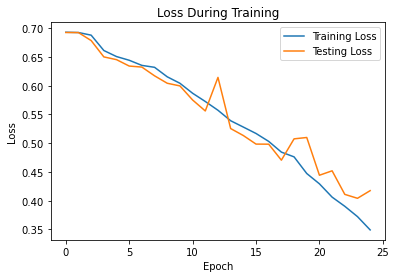

In [10]:
# === Plot the Data === #
plt.plot( history_dict['loss']     , label='Training Loss' )
plt.plot( history_dict['val_loss'] , label='Testing Loss' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Loss During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Visualize Accuracy

This next cell shows a plot of the training and validation accuracy for the model (the exact results are saved in a future cell for later processing in another notebook.

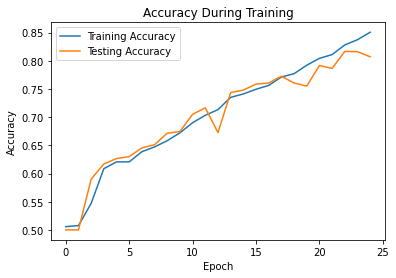

In [11]:
# === Plot the Data === #
plt.plot( history_dict['accuracy']     , label='Training Accuracy' )
plt.plot( history_dict['val_accuracy'] , label='Testing Accuracy'  )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Save the Model 

Now that the model has been fully trained, we want to save the learned weights in order to be further evaluated later if needed. 

In [16]:
# === Save for Future Evaluation === #
hypermodel.save( 'SmallGrayReg_Results/TUNED_vgg19_catvdog_model.h5' )

## Display Runtimes

We will show the measured preprocessing overhead time and the training time of this program in order to gain an understanding of the behavior of this baseline application. These resutls are saved in a future slide for later processing in a different notebook. 

In [17]:
for t in times:
    print( '{}: {}s'.format( t['Event'] , round( t['Time (sec)'] , 4 ) ) )

Load/Process Dataset: 11.1982s
Hyperparameter Tuning: 485.0638s
Training: 585.2392s


## Save Time Data

The above data is converted into a pandas DataFrame for saving into a formatted CSV file. This csv file will be used for processing in a different notebook. 

In [18]:
time_data  = {
    'Event': [t['Event'] for t in times],
    'Time (sec)': [t['Time (sec)'] for t in times]
}
time_table = pd.DataFrame( time_data )
time_table.to_csv( 'SmallGrayReg_Results/TUNED_vgg19_catvdog_times.csv' , index=False )
time_table.head( )

,Event,Time (sec)
0,Load/Process Dataset,11.198183
1,Hyperparameter Tuning,485.063778
2,Training,585.239221


## Save Training/Validation Data

Finally, construct a pandas dataframe of the training loss, validation loss, training accuracy, and validation accuracy at each epoch during training. These values are saved for processing in a different notebook. 

In [19]:
model_data = {
    'Epoch': [i+1 for i in range(25)],
    'Training Accuracy': history_dict['accuracy'],
    'Validation Accuracy': history_dict['val_accuracy'],
    'Training Loss': history_dict['loss'],
    'Validation Loss': history_dict['val_loss']
}
model_table = pd.DataFrame( model_data )
model_table.to_csv( 'SmallGrayReg_Results/TUNED_vgg19_catvdog_history.csv' , index=False )
model_table.head( len( model_table ) )

,Epoch,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1,0.505875,0.5000,0.693050,0.692609
1,2,0.507625,0.5000,0.692564,0.692447
2,3,0.547125,0.5900,0.687962,0.678570
3,4,0.608625,0.6170,0.661276,0.650166
4,5,0.620625,0.6265,0.650750,0.645373
5,6,0.620625,0.6300,0.644333,0.634250
6,7,0.638750,0.6455,0.635391,0.632453
7,8,0.647125,0.6510,0.632061,0.617247
8,9,0.658250,0.6715,0.615536,0.604326
9,10,0.672125,0.6745,0.604287,0.599705
